# **Table Of Contents**
1. Problem Statement and Research Question
2. Data Exploration and Visualization
3. Baseline Models (Majority Class, Linear Regression)
4. Interpreting Models and Results
5. Final Model Pipeline (Logistic Regression, kNN)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statement and Research Question**

**Question:** Can New York Times headlines provide us with information that we can use to predict changes in the S&P 500?

**Description:** Using various sentiment analysis methods (VADER and TextBlob), we computed a score for each NYT headline (2.1 million). Each headline includes a date and section field as well. NYT headlines were collected from 1990 to 2020 (avoiding harder to predict post-COVID fluctuations in the market). Subsequent S&P 500 data closing prices have been collected at each time period during this timeframe, and we scaled these values to account for inflation.

**Approach:** To do this, we created a dataframe with an entry for each time point. For that time point, we average the sentiment scores for that day, and also add the number of headlines from each section into the row. Finally, our response is the S&P 500 closing price.

For the sentiment analysis, we used two different methods - VADER and TextBlob - to give a score to each NYT article headline. Due to the short nature of each headline (on average 6 words or less), the majority of scores are 0, thus we exclude sentiment scores of 0 in order to assess either a positive or negative value for the time period - we will experiment with this threshold. Finally, the timepoints we are testing will be day, week, month, and year. This means we have a df where each row is a day date (averaged sentiment scores for that day and S&P closing price for that day), week (averaged sentiment scores for that day and averaged S&P closing price for that week) and so on.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>


# **Data Exploration and Visualization**

In our previous milestone 3, we created 4 dataframes each for 1 day, 1 week, 1 month, and 1 year time points. In the file, we also updated this code to separate our headlines into a train / test split of 15%. To do this, the 15% of headlines per day were randomly selected to create a day/week/month/year test df with all the same features as the train dfs. In total, we have 8 dataframes found in the **df_train_test** folder, each separated as described in the previous molestone file.

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

### **File Description Post Cleaning**

1. __daily_test.xlsx & daily_train.xlsx__
    Average sentiment of the day's headlines, and number of headlines in each section for that date. Closing price for the day.
3. __weekly_test.xlsx & weekly_train.xlsx__
    Average sentiment of the week's headlines, and number of headlines in each section for that week. Average closing price for the week.
3. __monthly_test.xlsx & monthly_train.xlsx__
    Average sentiment of the months's headlines, and number of headlines in each section for that month. Average closing price for the month.
4. __yearly_test.xlsx & yearly_train.xlsx__
    Average sentiment of the year's headlines, and number of headlines in each section for that year. Average closing price for the year.

In [252]:
# Load in files from the folder which were saved from milestone 3 (train test split 15%)
daily_train = pd.read_excel("df_train_test/daily_train.xlsx", index_col=0)
weekly_train = pd.read_excel("df_train_test/weekly_train.xlsx", index_col=0)
monthly_train = pd.read_excel("df_train_test/monthly_train.xlsx", index_col=0)
yearly_train = pd.read_excel("df_train_test/yearly_train.xlsx", index_col=0)

daily_test = pd.read_excel("df_train_test/daily_test.xlsx", index_col=0)
weekly_test = pd.read_excel("df_train_test/weekly_test.xlsx", index_col=0)
monthly_test = pd.read_excel("df_train_test/monthly_test.xlsx", index_col=0)
yearly_test = pd.read_excel("df_train_test/yearly_test.xlsx", index_col=0)


We will scale all the computed values from -1 to 1 to best visualize our results. We will do this for VADER and TextBlob (both with and without zero values), percent change, and closing price.

In [253]:
# -1 to 1 scaling
def scale_column(data, column):
    min_val = data[column].min()
    max_val = data[column].max()
    data[f"{column}_scaled"] = 2 * (data[column] - min_val) / (max_val - min_val) - 1

datasets = [daily_train, daily_test, weekly_train, weekly_test, monthly_train, monthly_test, yearly_train, yearly_test]
columns_to_scale = [ "sentiment_score_VADER", "score_textblob", "sentiment_score_VADER_nonzero", "score_textblob_nonzero", "Inflation_Adjusted_Close", "Pct_Change" ]

for df in datasets:
    for col in columns_to_scale:
        if col in df.columns:
            scale_column(df, col)

In [254]:
# Just to check that all train files have same colums, and also to look at them.
daily_columns = set(daily_train.columns)
all_same_columns = (
    daily_columns == set(weekly_train.columns) ==
    set(monthly_train.columns) ==
    set(yearly_train.columns)
)

print("Columns in each of the dataframes shown below:")
display(daily_columns)
print("\nChecking that all the colums are consistent across the dataframes: ")
print(all_same_columns)

Columns in each of the dataframes shown below:


{'Admin',
 'Archives',
 'Arts',
 'At Home',
 'Automobiles',
 'Blogs',
 'Books',
 'Booming',
 'Briefing',
 'Burst',
 'Business Day',
 'Climate',
 'College',
 'Corrections',
 "Critic's Choice",
 'Crosswords & Games',
 'Editors Picks',
 'Education',
 'Fashion & Style',
 'Feeds',
 'Food',
 'Giving',
 'Global Home',
 'Great Homes & Destinations',
 'Guides',
 'Health',
 'Home & Garden',
 'Homepage',
 'Inflation_Adjusted_Close',
 'Inflation_Adjusted_Close_scaled',
 'International Home',
 'Job Market',
 'Lens',
 'Magazine',
 'Movies',
 'Multimedia/Photos',
 'NYT Now',
 'Neediest Cases',
 'New York',
 'Obituaries',
 'Open',
 'Opinion',
 'Parenting',
 'Pct_Change',
 'Pct_Change_scaled',
 'Podcasts',
 'Public Editor',
 'Reader Center',
 'Real Estate',
 'Science',
 'Slideshows',
 'Smarter Living',
 'Sports',
 'Style',
 'Sunday Review',
 'T Brand',
 'T Magazine',
 'Technology',
 'The Learning Network',
 'The Upshot',
 'The Weekly',
 'Theater',
 'Times Insider',
 'Times Topics',
 'Today’s Paper',
 '


Checking that all the colums are consistent across the dataframes: 
True


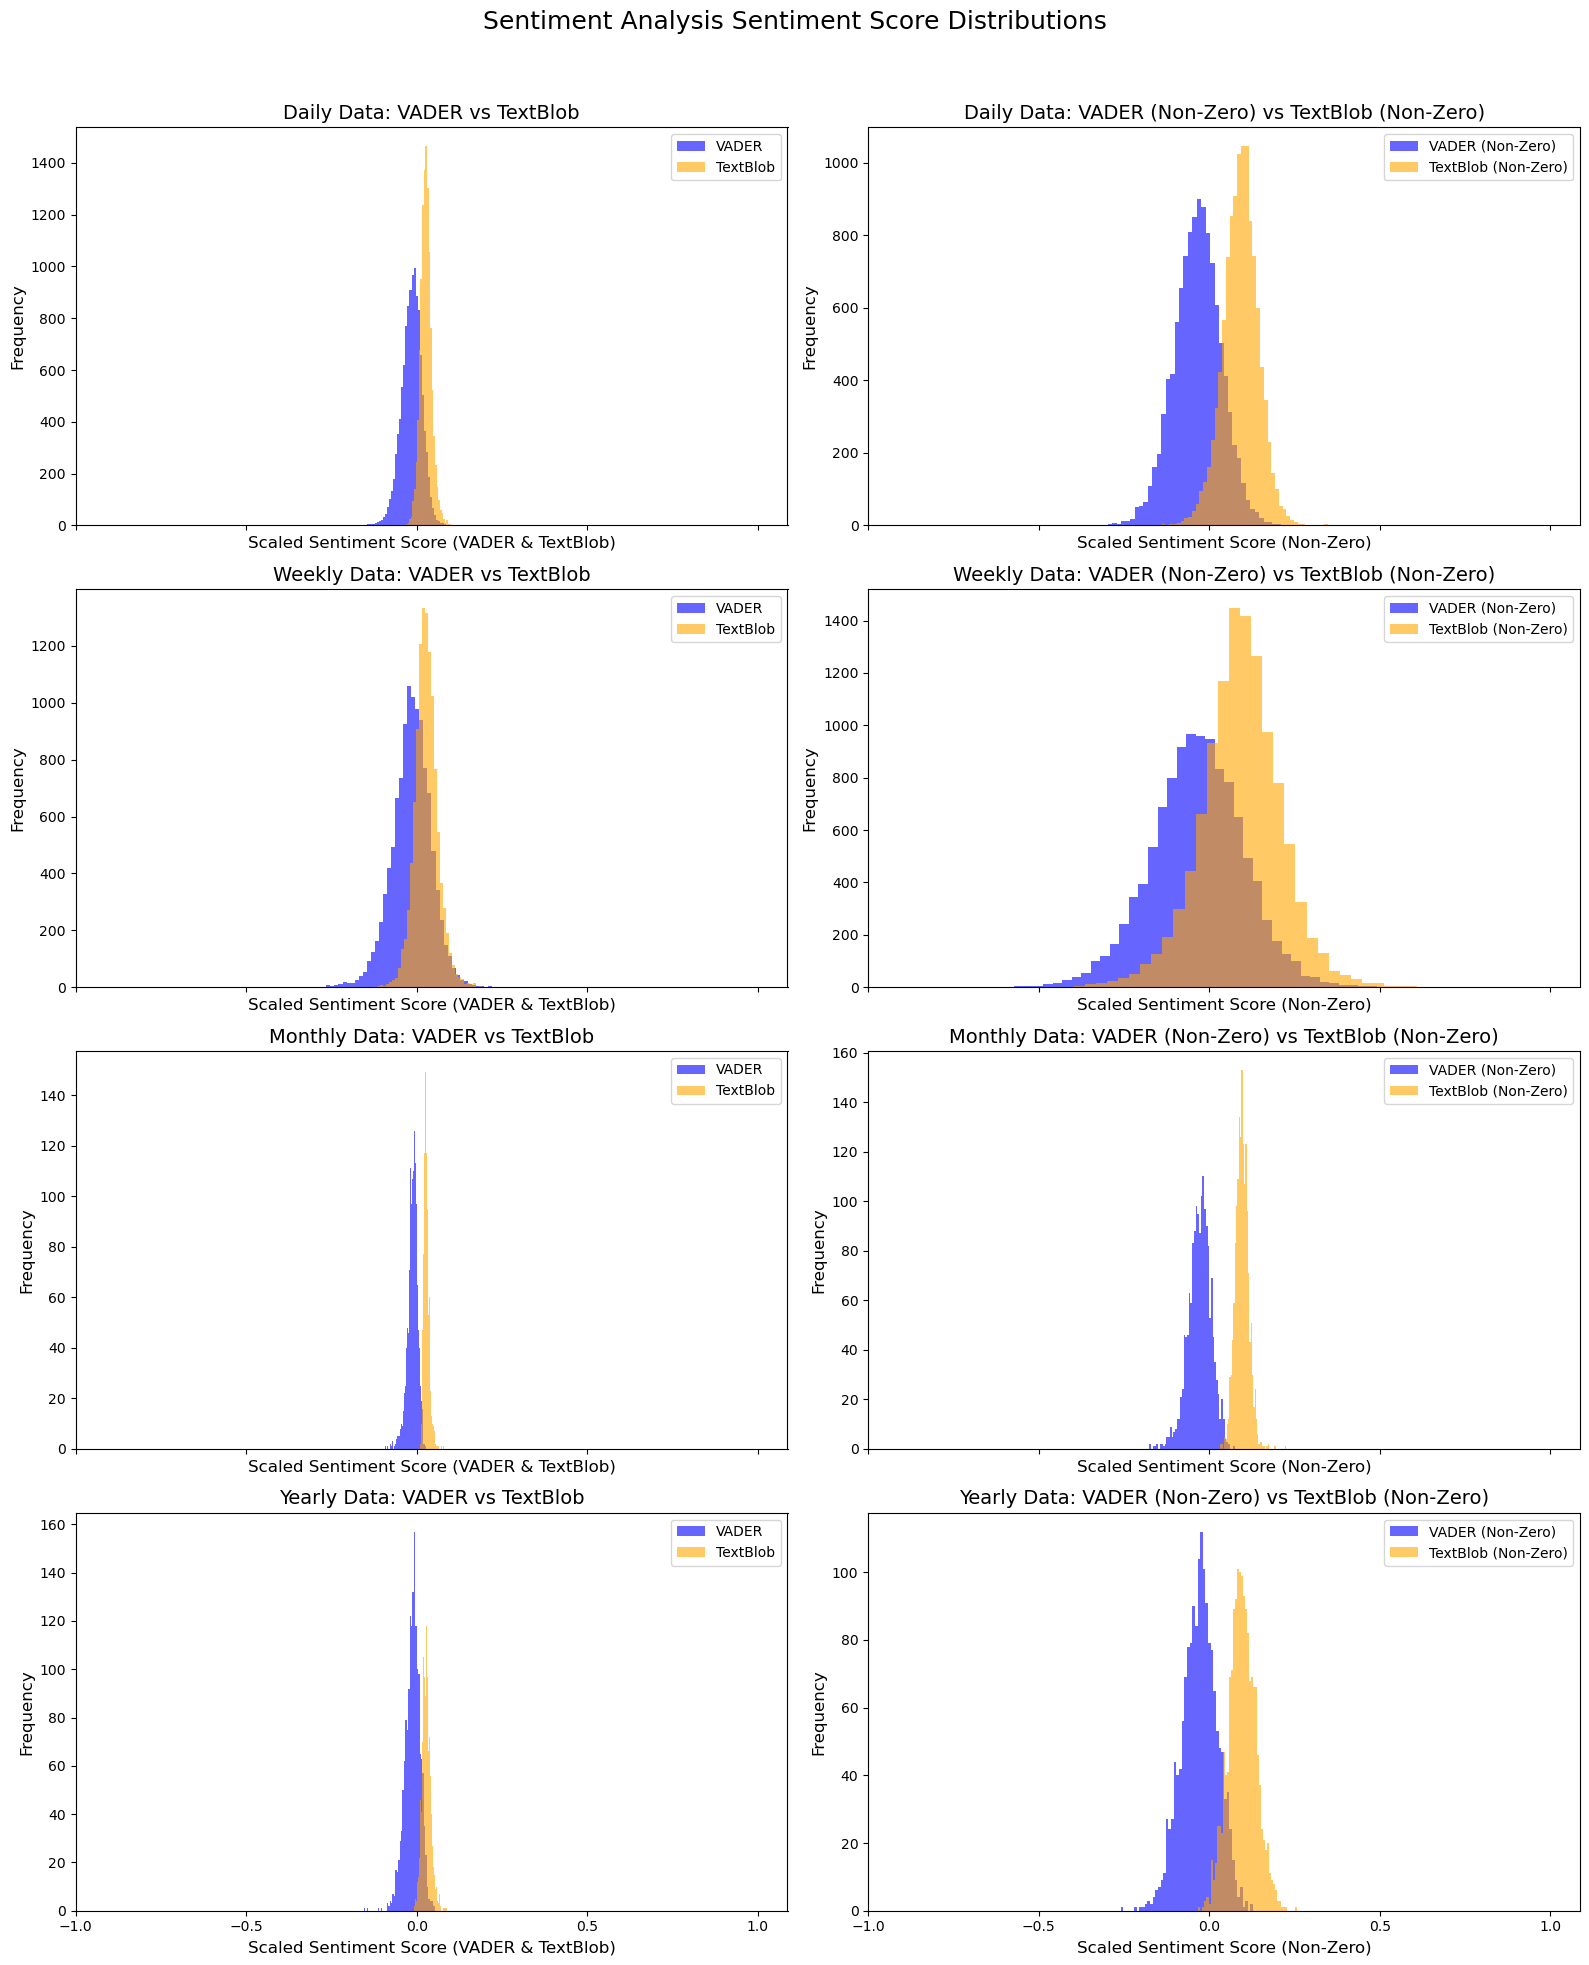

In [255]:
def plot_sentiment_distributions(datasets, title_prefix):
    fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex=True, sharey=False)
    fig.suptitle(f"{title_prefix} Sentiment Score Distributions", fontsize=18)

    freqs = ["Daily", "Weekly", "Monthly", "Yearly"]

    for i, (freq, df) in enumerate(zip(freqs, datasets)):
        axes[i, 0].hist(df['sentiment_score_VADER'], bins=50, alpha=0.6, label='VADER', color='blue')
        axes[i, 0].hist(df['score_textblob'], bins=50, alpha=0.6, label='TextBlob', color='orange')
        axes[i, 0].set_title(f"{freq} Data: VADER vs TextBlob", fontsize=14)
        axes[i, 0].set_xlabel('Scaled Sentiment Score (VADER & TextBlob)', fontsize=12)
        axes[i, 0].set_ylabel('Frequency', fontsize=12)
        axes[i, 0].legend()
        axes[i, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
        axes[i, 0].tick_params(axis='x', labelsize=10)

        #For the overlapping histogram
        axes[i, 1].hist(df['sentiment_score_VADER_nonzero'], bins=50, alpha=0.6, label='VADER (Non-Zero)', color='blue')
        axes[i, 1].hist(df['score_textblob_nonzero'], bins=50, alpha=0.6, label='TextBlob (Non-Zero)', color='orange')
        axes[i, 1].set_title(f"{freq} Data: VADER (Non-Zero) vs TextBlob (Non-Zero)", fontsize=14)
        axes[i, 1].set_xlabel('Scaled Sentiment Score (Non-Zero)', fontsize=12)
        axes[i, 1].set_ylabel('Frequency', fontsize=12)
        axes[i, 1].legend()
        axes[i, 1].set_xticks([-1, -0.5, 0, 0.5, 1]) 
        axes[i, 1].tick_params(axis='x', labelsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_sentiment_distributions(datasets, "Sentiment Analysis")


We can notice that the VADER scores are on average more negative than the TextBlob scores for NYT headlines. We also can see that removing non-zero sentiment scores worked, as these distributions have greater interdistribution variability for all time points.

Now, we can do EDA to explore the best time frame (D, W, M, Y) and also analyze and sentiment analysis method might be best. To do this, let's make a plot of all the different combinations of Sentiment analysis vs. Closing Price and Sentiment analysis vs. Percent Change.

In [256]:
def plot_sentiment_subplots(data_dict, sentiment_column, close_column, title_prefix, nonzero=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"{title_prefix} Sentiment vs. Normalized Closing Price", fontsize=16)

    for ax, (freq, data) in zip(axes.flat, data_dict.items()):
        filtered_data = data if not nonzero else data[data[sentiment_column] != 0]

        years = filtered_data.index.year
        cmap = cm.get_cmap("viridis")
        norm = plt.Normalize(years.min(), years.max())
        colors = cmap(norm(years))

        ax.scatter(filtered_data[sentiment_column], filtered_data[close_column], c=colors, alpha=0.6)
        ax.set_title(f"{freq.capitalize()} Data", fontsize=14)
        ax.set_xlabel(sentiment_column, fontsize=12)
        ax.set_ylabel(close_column, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

def plot_sentiment_vs_pct_change(data_dict, sentiment_column, pct_column, title_prefix, nonzero=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"{title_prefix} Sentiment vs. Percent Change", fontsize=16)

    for ax, (freq, data) in zip(axes.flat, data_dict.items()):
        filtered_data = data if not nonzero else data[data[sentiment_column] != 0]

        years = filtered_data.index.year
        cmap = cm.get_cmap("viridis")
        norm = plt.Normalize(years.min(), years.max())
        colors = cmap(norm(years))

        ax.scatter(filtered_data[sentiment_column], filtered_data[pct_column], c=colors, alpha=0.6)
        ax.set_title(f"{freq.capitalize()} Data", fontsize=14)
        ax.set_xlabel(sentiment_column, fontsize=12)
        ax.set_ylabel(pct_column, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

data_dict = {"Daily": daily_train, "Weekly": weekly_train, "Monthly": monthly_train, "Yearly": yearly_train}


### **Sentiment Score (Both VADER and TextBlob) vs. Closing Price and Percent Change**

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_67674/1332258256.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


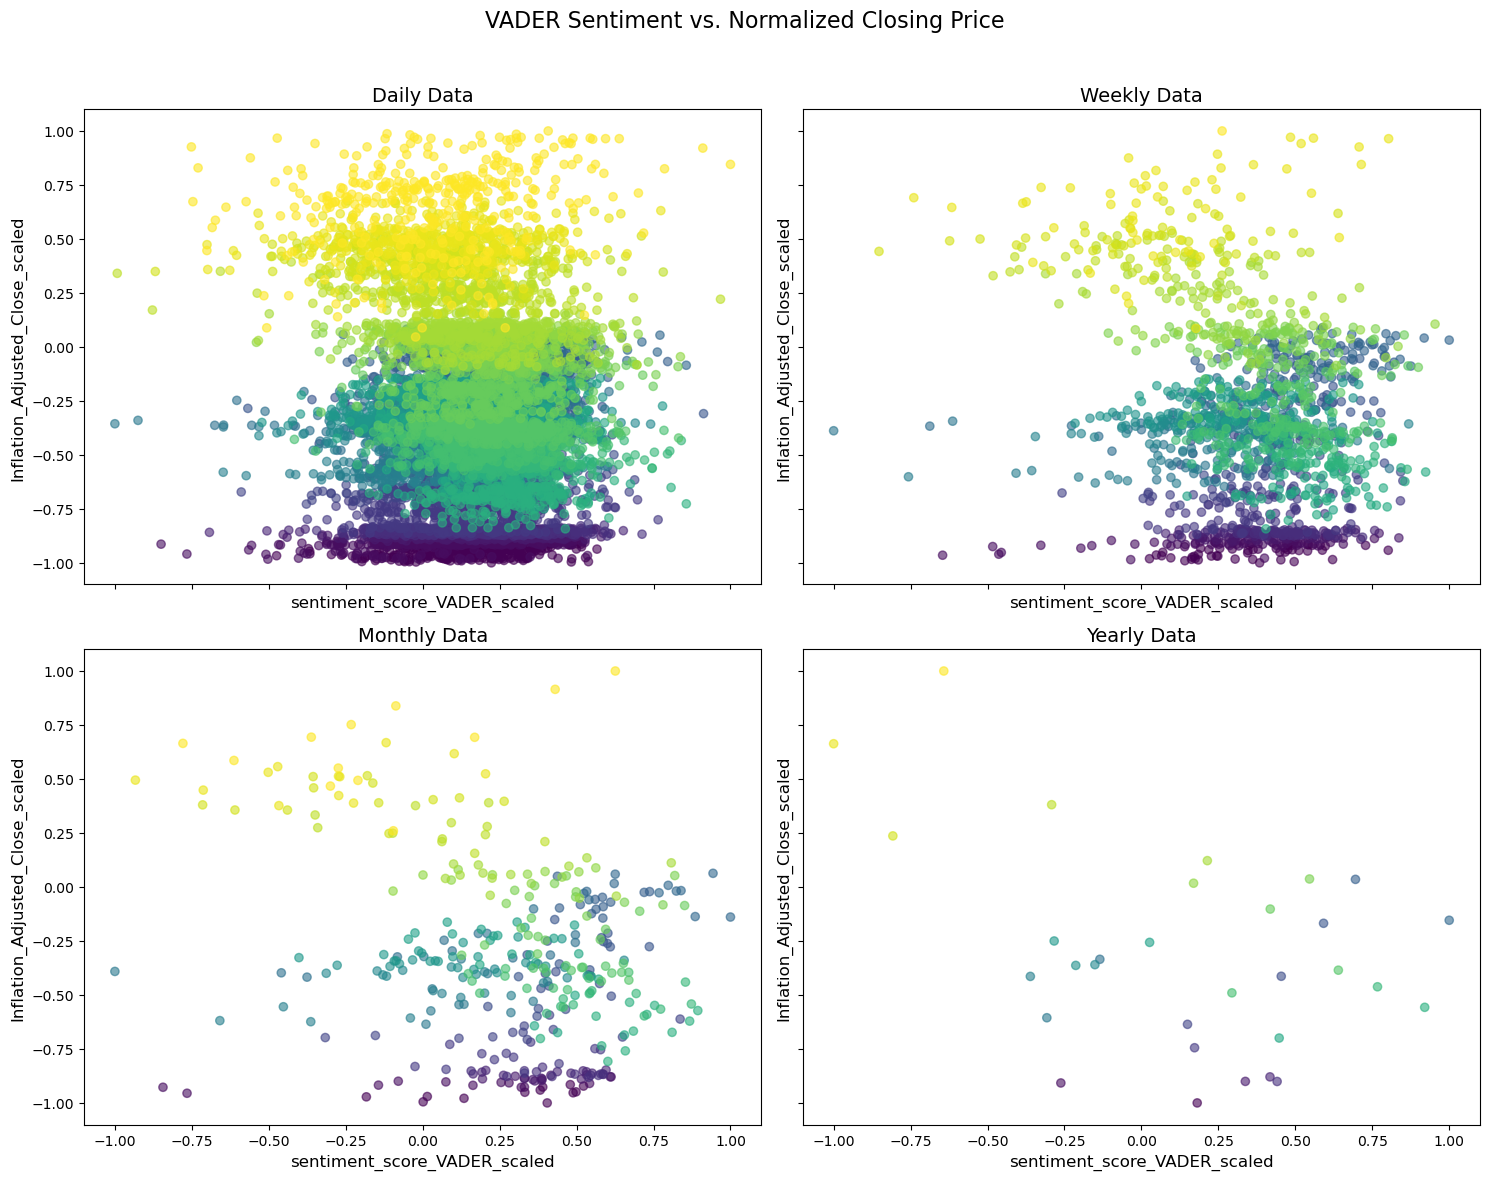

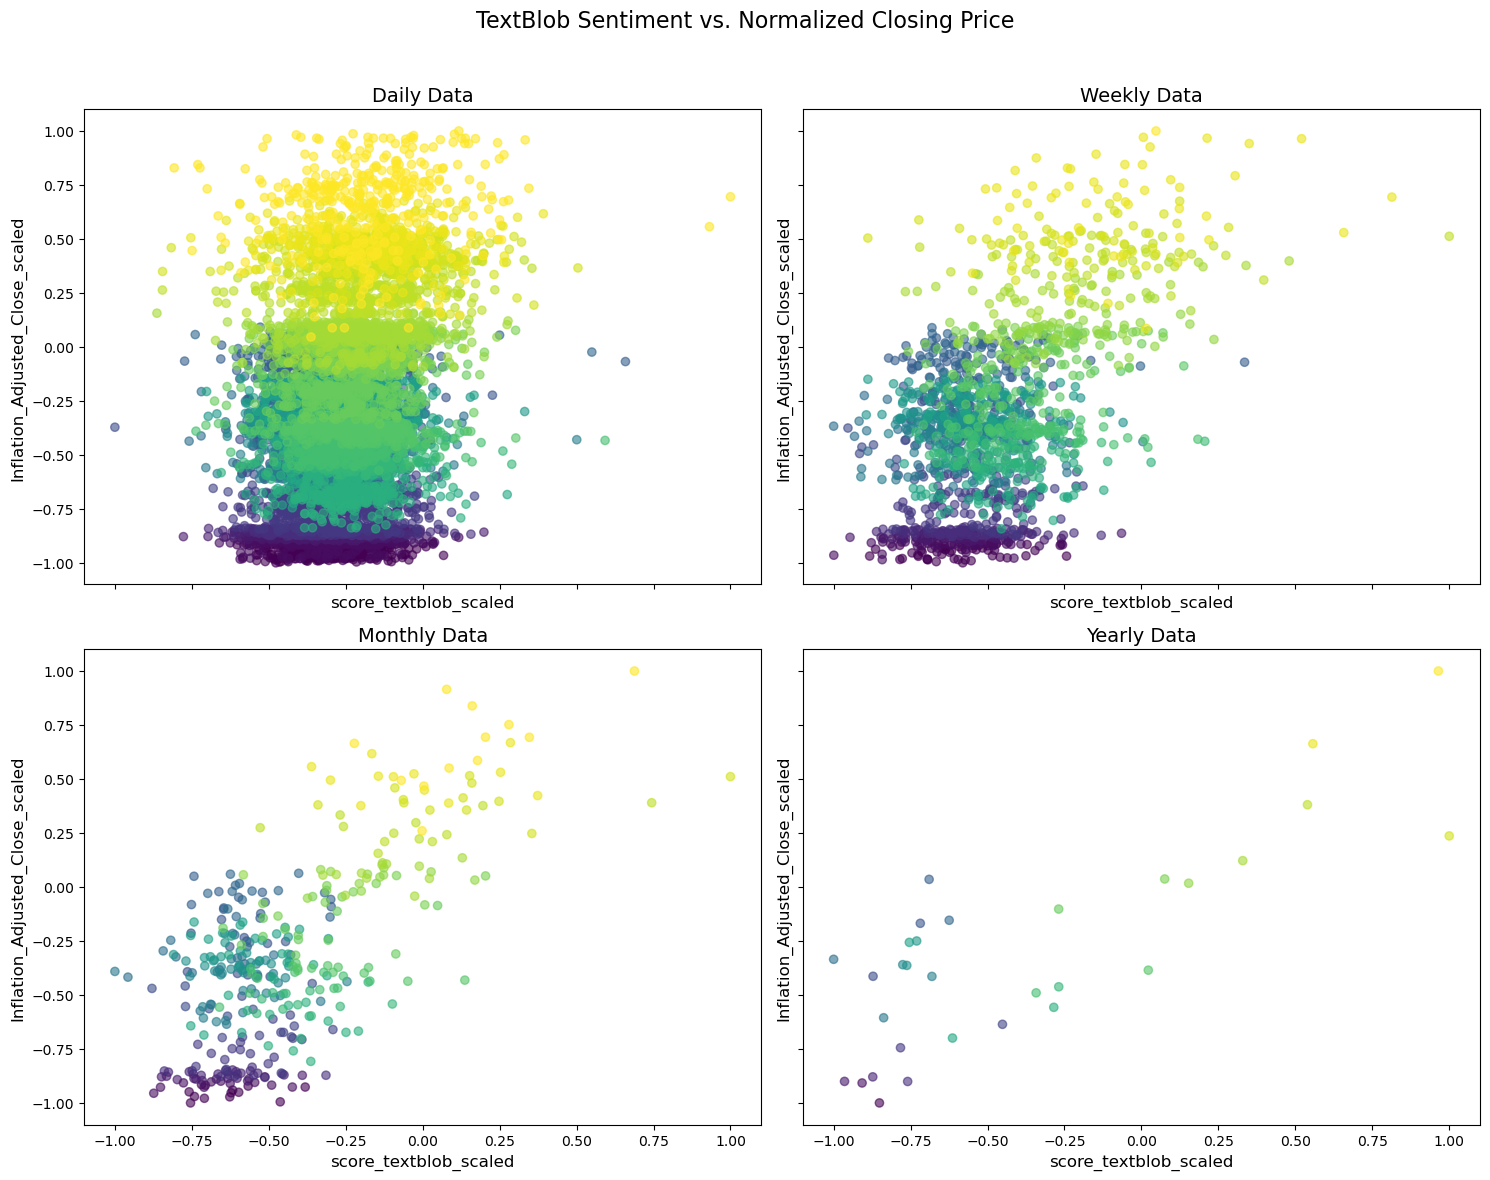

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_67674/1332258256.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


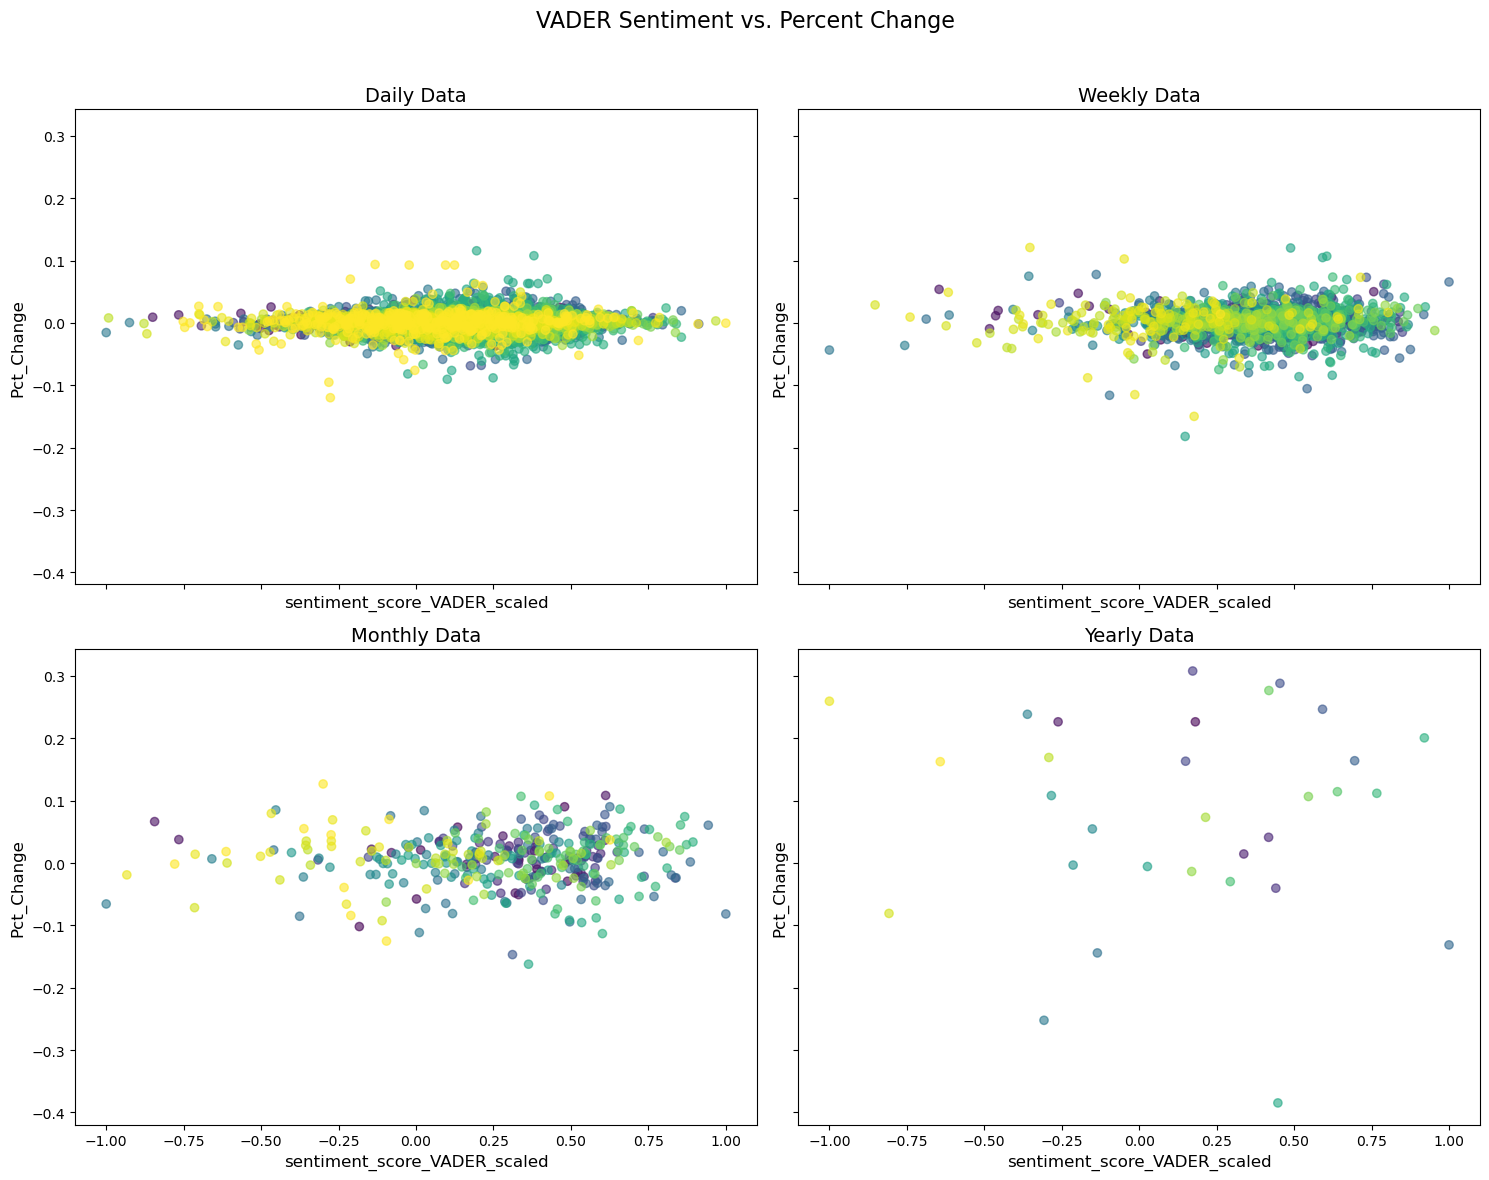

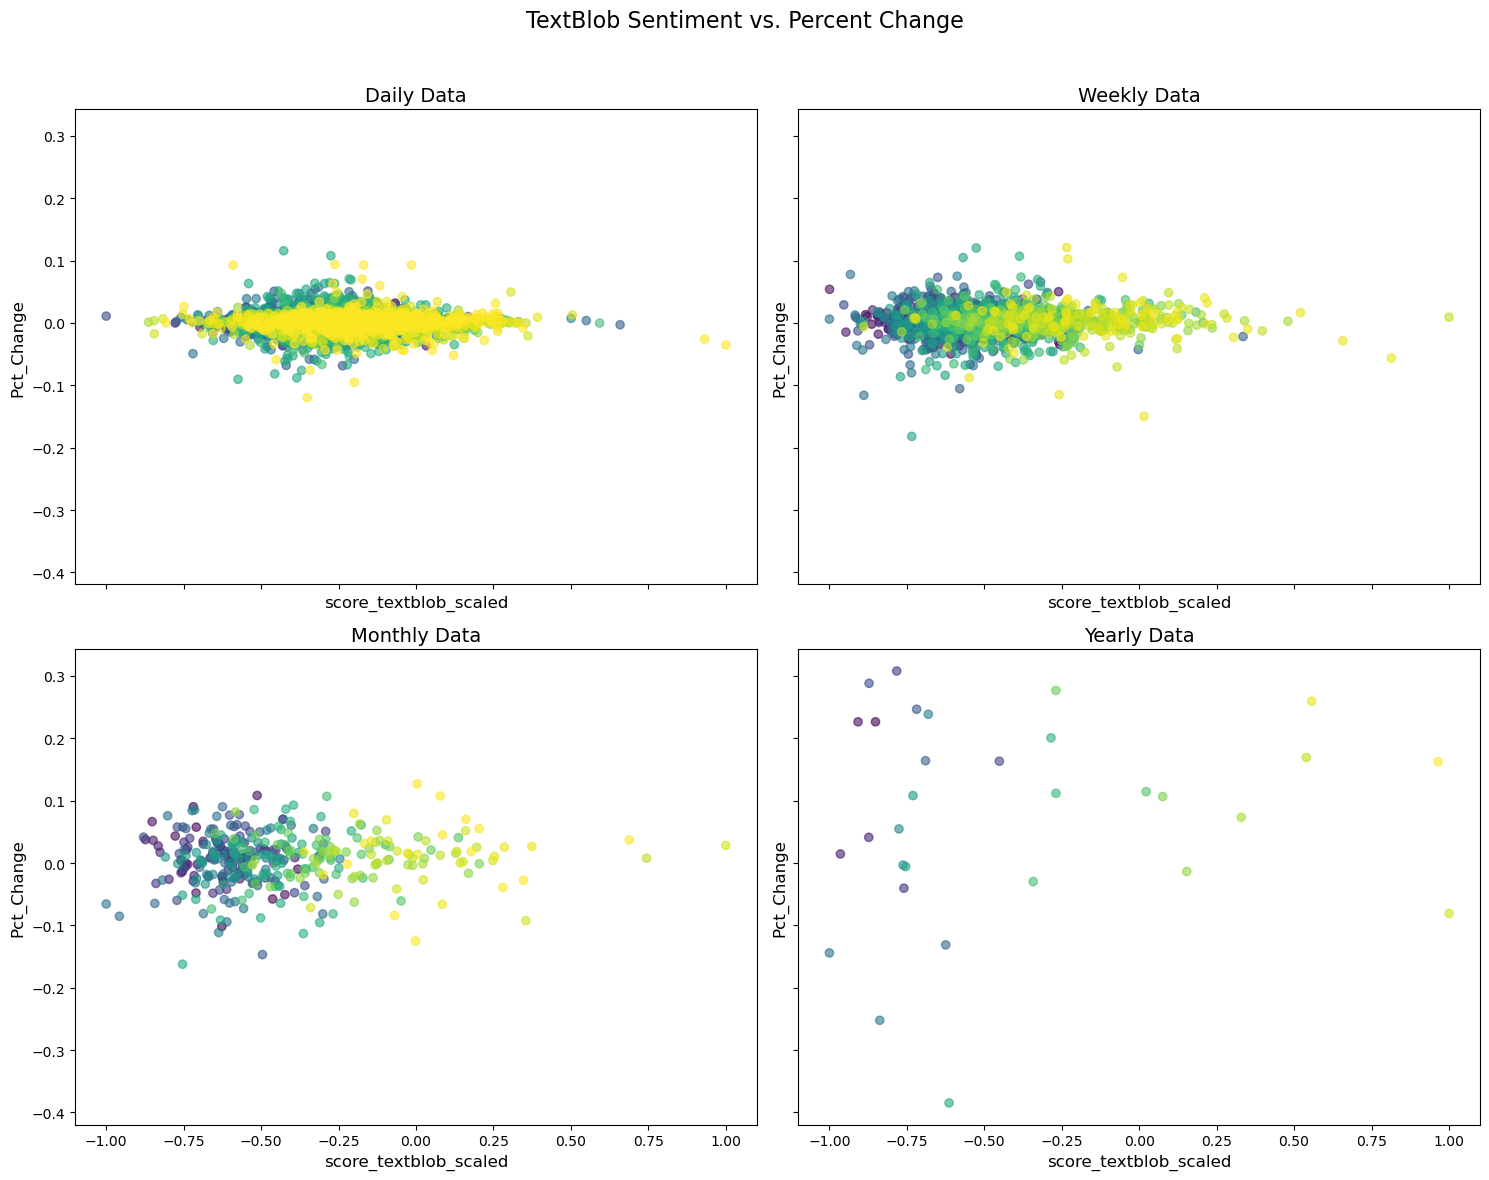

In [257]:
plot_sentiment_subplots(data_dict, 'sentiment_score_VADER_scaled', 'Inflation_Adjusted_Close_scaled', "VADER", nonzero=False)
plot_sentiment_subplots(data_dict, 'score_textblob_scaled', 'Inflation_Adjusted_Close_scaled', "TextBlob", nonzero=False)

plot_sentiment_vs_pct_change(data_dict, 'sentiment_score_VADER_scaled', 'Pct_Change', "VADER", nonzero=False)
plot_sentiment_vs_pct_change(data_dict, 'score_textblob_scaled', 'Pct_Change', "TextBlob", nonzero=False)

### **Sentiment Score (Both VADER and TextBlob excluding nonzero scores) vs. Closing Price and Percent Change**

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_67674/1332258256.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


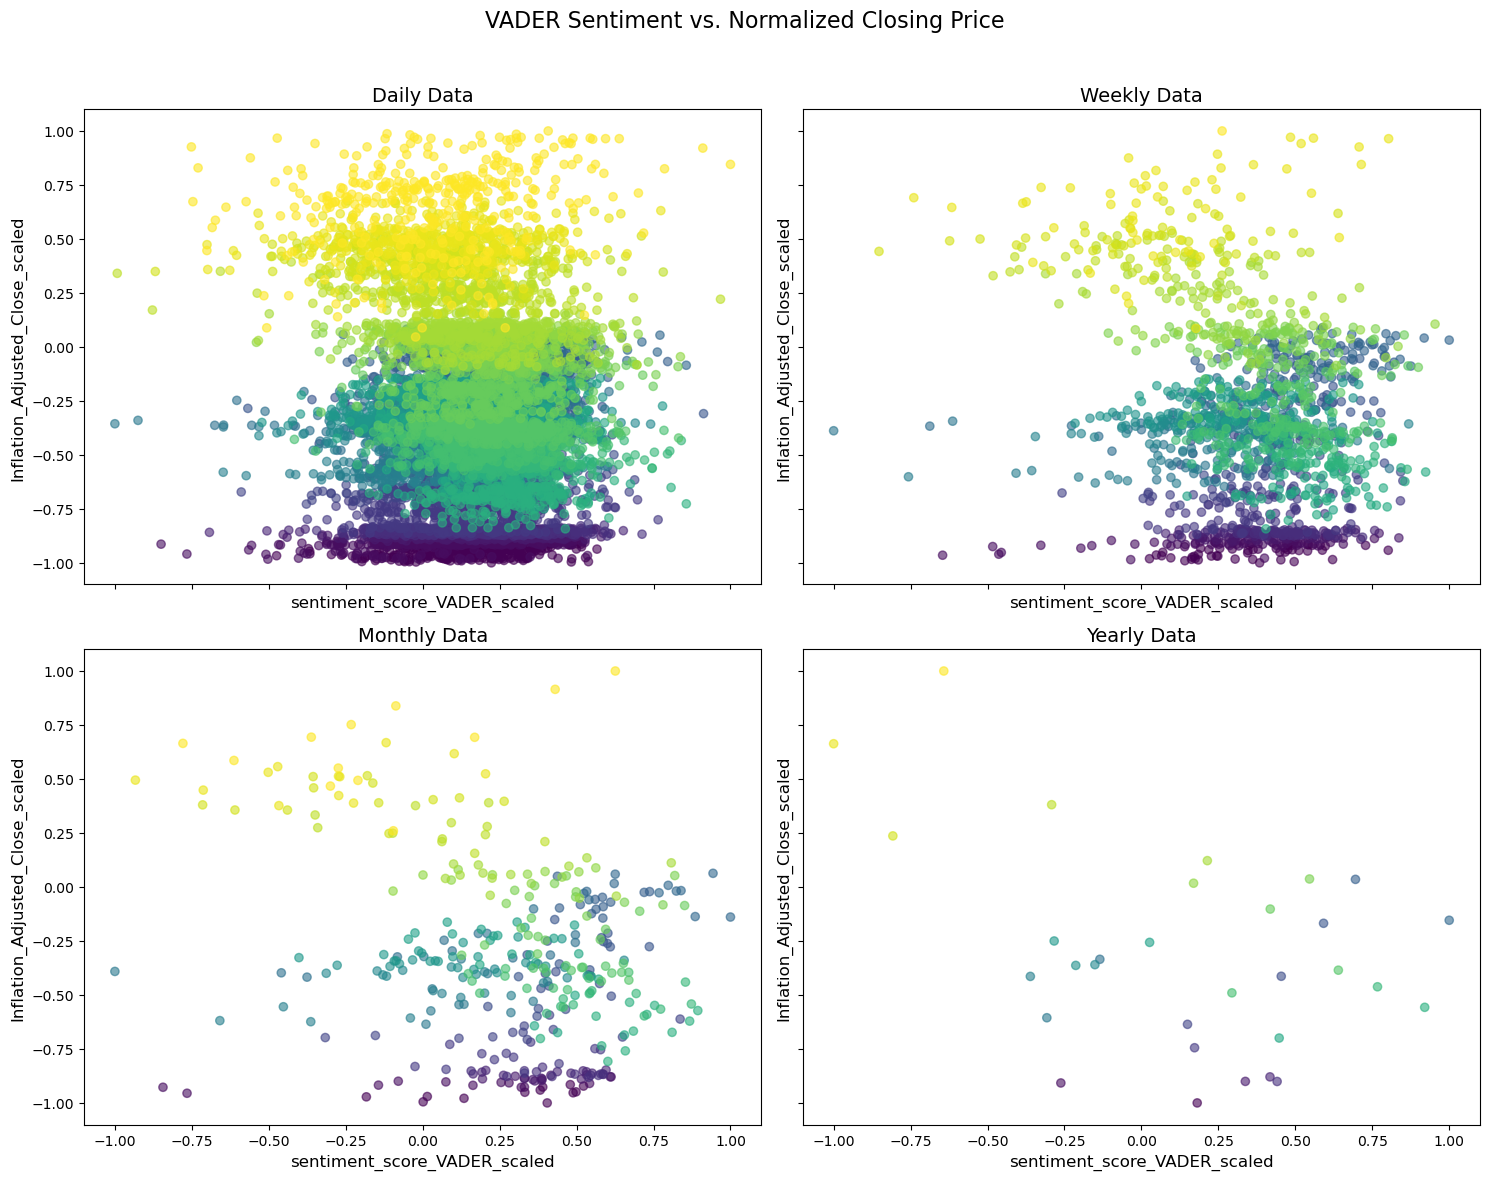

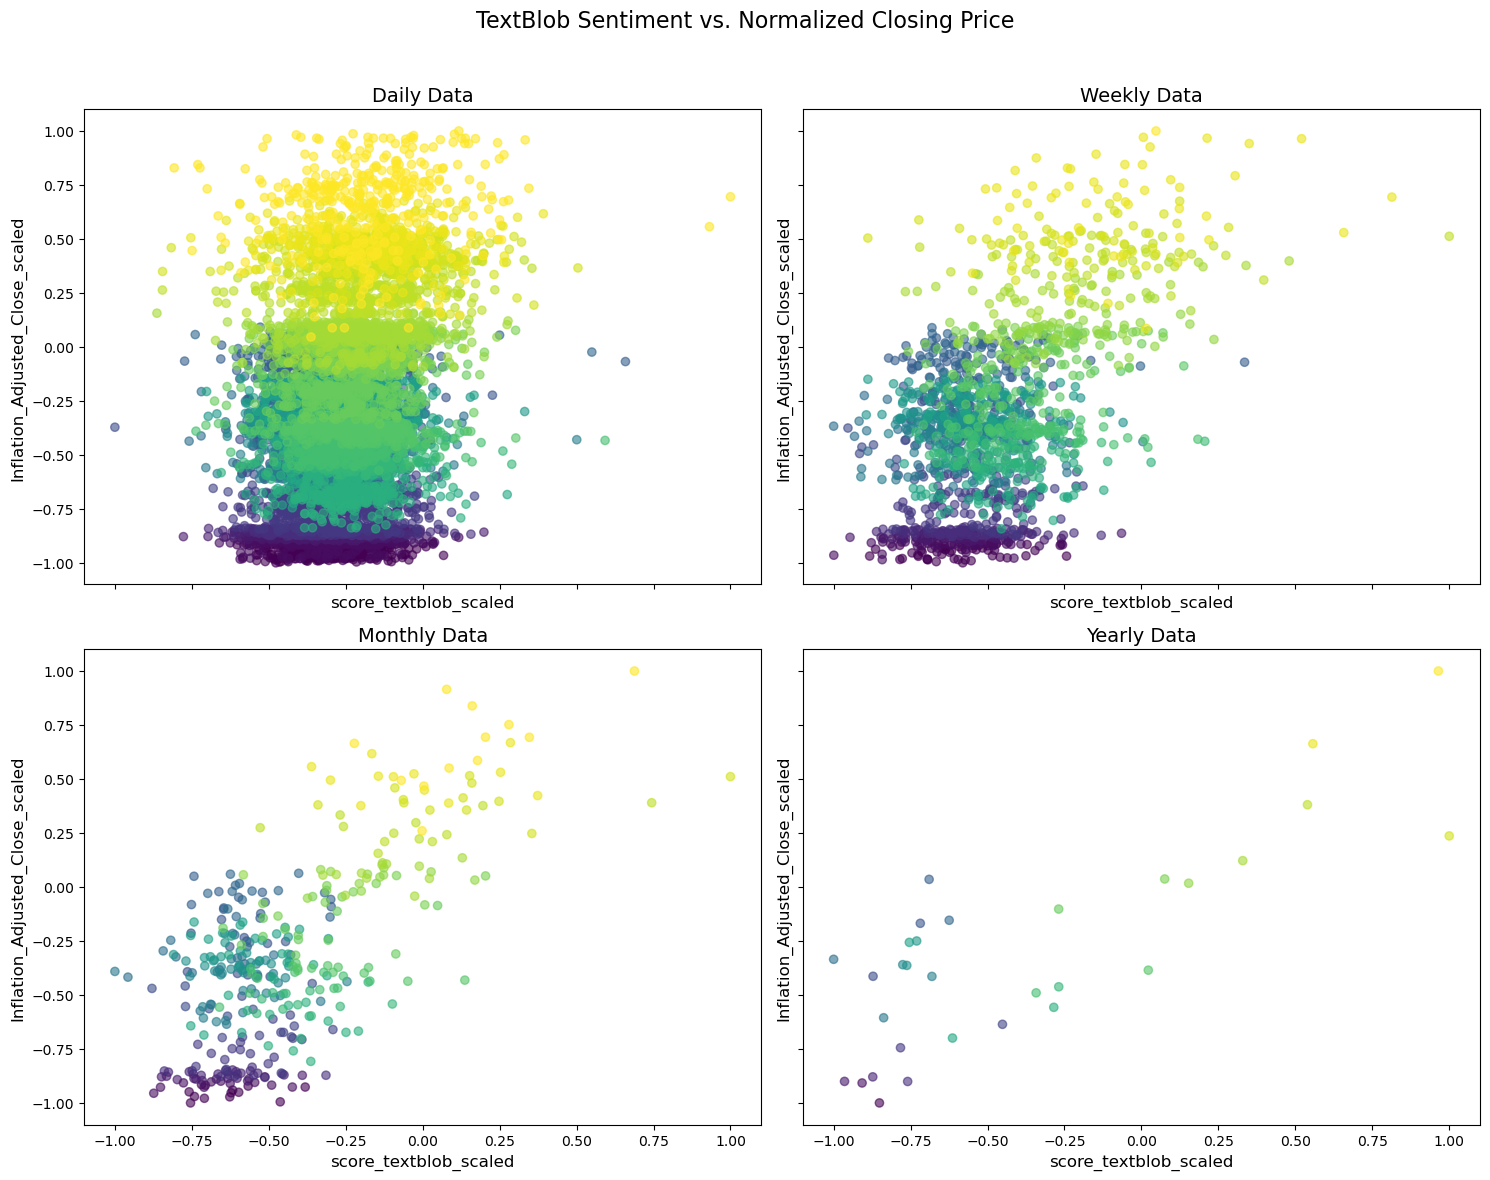

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_67674/1332258256.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


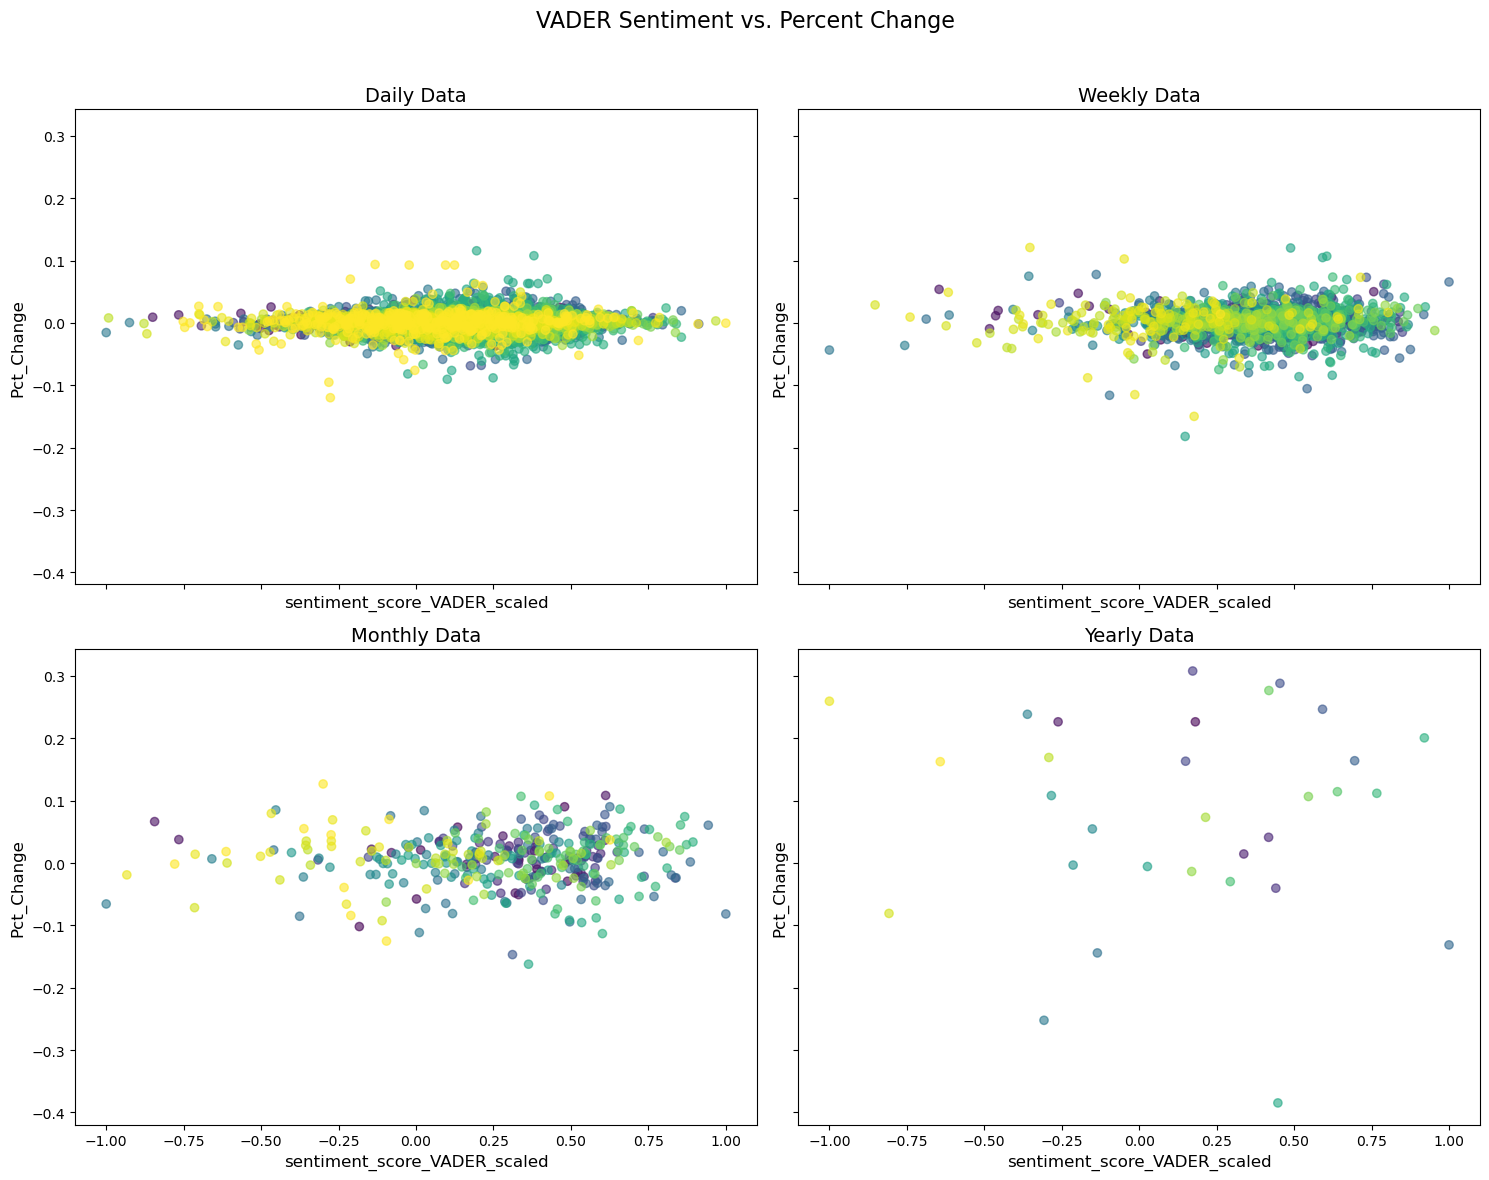

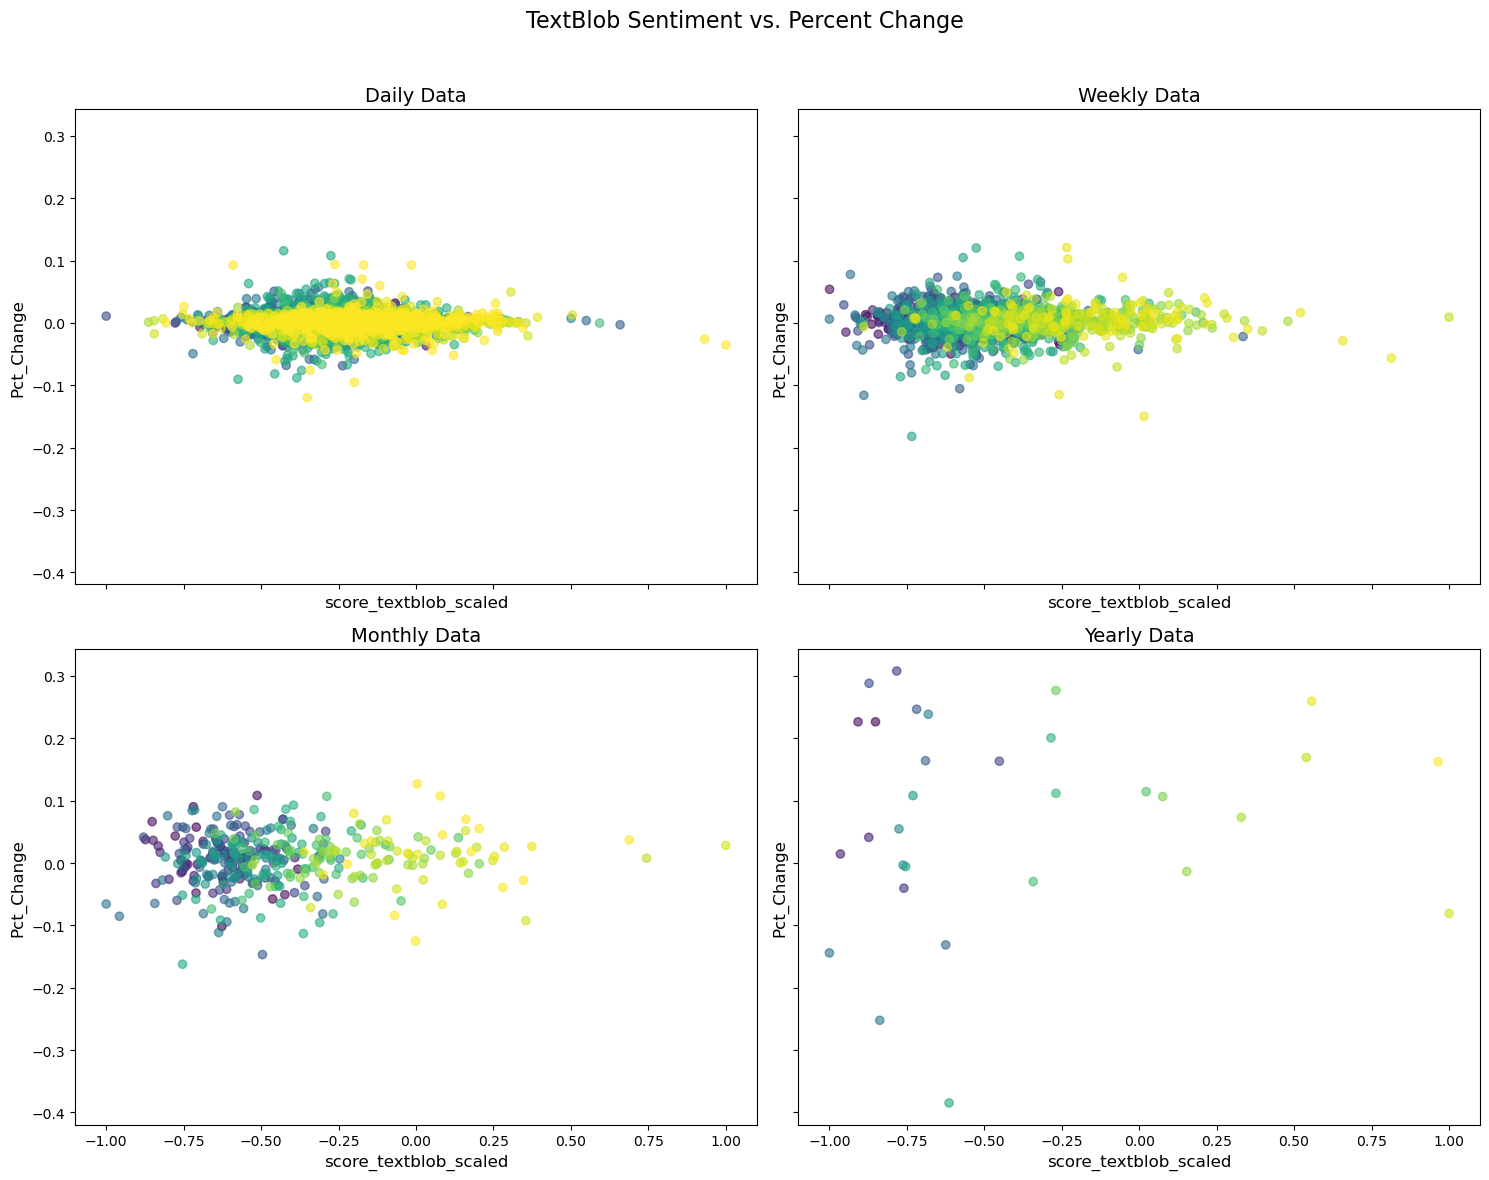

In [258]:
plot_sentiment_subplots(data_dict, 'sentiment_score_VADER_scaled', 'Inflation_Adjusted_Close_scaled', "VADER", nonzero=True)
plot_sentiment_subplots(data_dict, 'score_textblob_scaled', 'Inflation_Adjusted_Close_scaled', "TextBlob", nonzero=True)

plot_sentiment_vs_pct_change(data_dict, 'sentiment_score_VADER_scaled', 'Pct_Change', "VADER", nonzero=True)
plot_sentiment_vs_pct_change(data_dict, 'score_textblob_scaled', 'Pct_Change', "TextBlob", nonzero=True)

We can see that there is a lot of noise in this data. This makes sense, because the S&P 500 is influenced by a lot of factors that are not accounted for only by scaling due to inflation. We see that accross most time points, S&P 500 percent change seems to have less of a relationship compared to scaled S&P 500 price. Nevertheless, we can see some relationship between monthly and yearly sentiment scores and S&P500 scaled closing price, specifically with TextBlob. VADER seems to provide less conclusive results. Notably, we mapped the points to a hue corrisponding to the date they are from. From this, we see that price increases with time generally, and so does TextBlob sentiment scores. In conclusion, from these graphs it seems that TextBlob sentiment scores (both zero and non-zero values) have some corrilation with S&P closing prices for the month and year time points. We decided to focus on month sentiment analysis since this could provide a more useful metric for predicting the S&P.

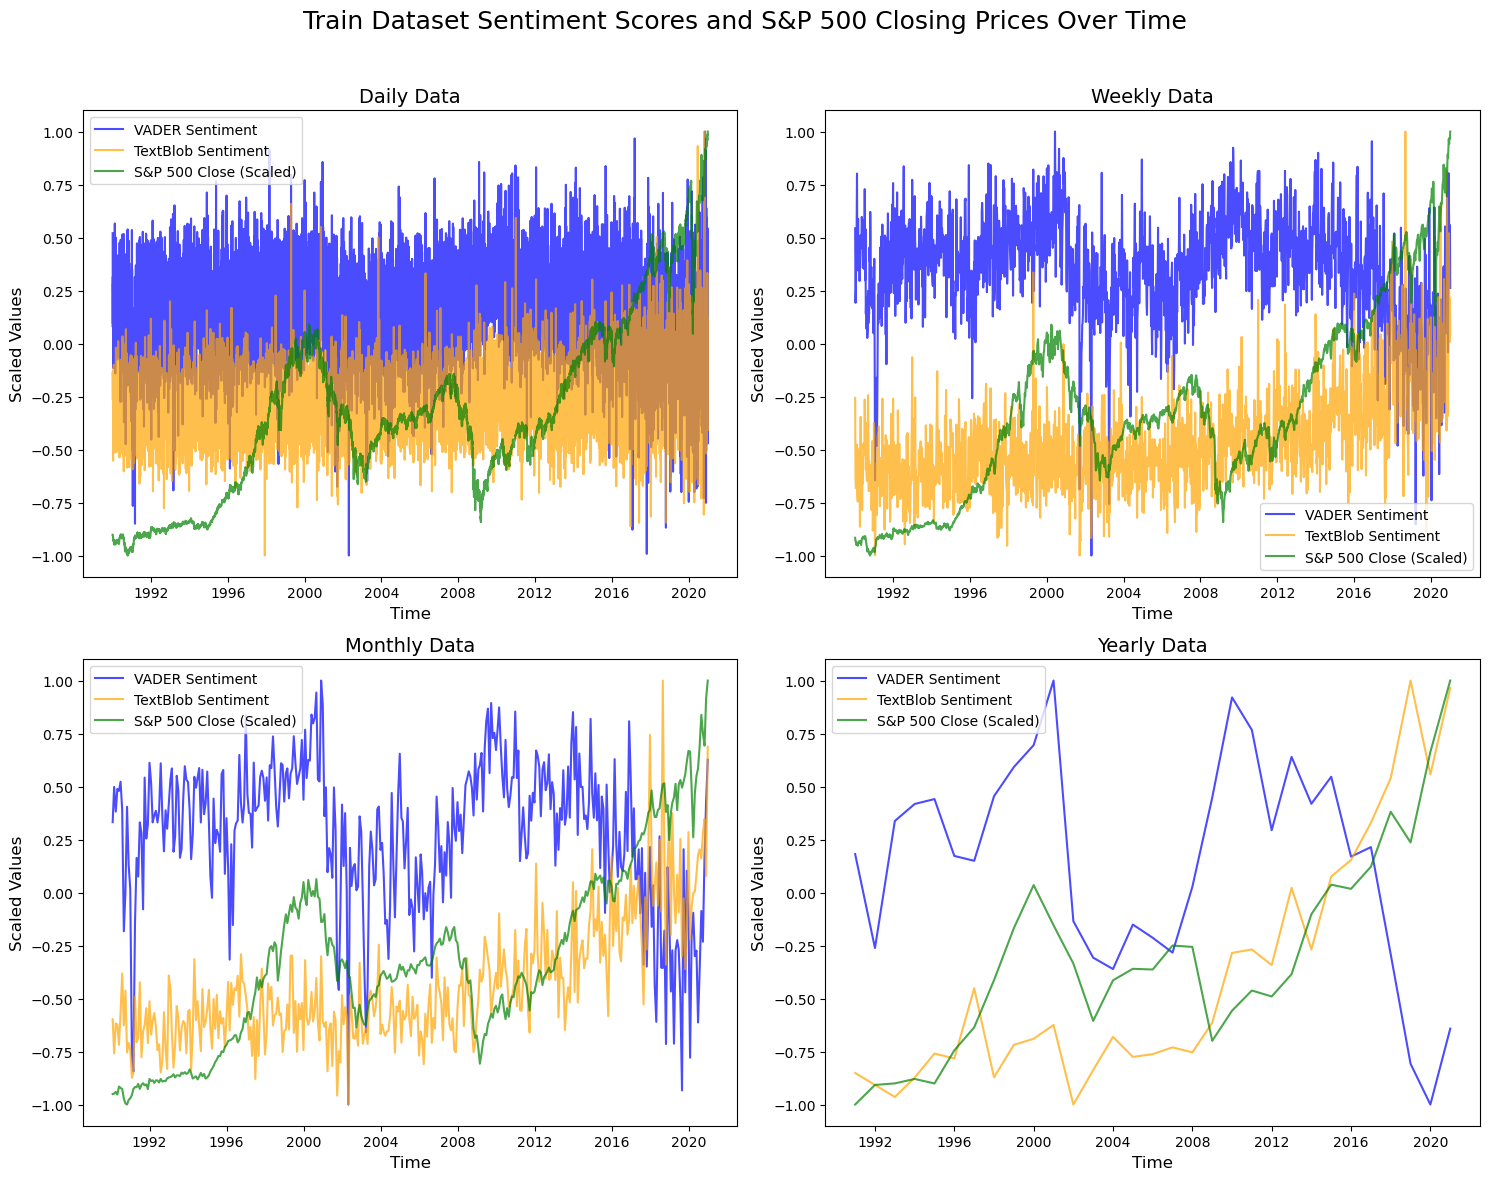

In [259]:
def plot_sentiment_and_sp500_over_time(datasets, title_prefix):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=False, sharey=False)
    fig.suptitle(f"{title_prefix} Sentiment Scores and S&P 500 Closing Prices Over Time", fontsize=18)

    freqs = ["Daily", "Weekly", "Monthly", "Yearly"]
    for ax, (freq, df) in zip(axes.flat, zip(freqs, datasets)):
        ax.plot(df.index, df['sentiment_score_VADER_scaled'], label='VADER Sentiment', color='blue', alpha=0.7)
        ax.plot(df.index, df['score_textblob_scaled'], label='TextBlob Sentiment', color='orange', alpha=0.7)

        ax.plot(df.index, df['Inflation_Adjusted_Close_scaled'], label='S&P 500 Close (Scaled)', color='green', alpha=0.7)

        ax.set_title(f"{freq} Data", fontsize=14)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Scaled Values', fontsize=12)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_sentiment_and_sp500_over_time(
    [daily_train, weekly_train, monthly_train, yearly_train],
    "Train Dataset"
)

This looks at sentiemnt scores over time vs. the closing price. In the day and week graphs, there is a lot of noise and it is hard to determine if the sentiment scores predict any changes in the price. In the monthly data, we can see that TextBlob sentiment more closley follows the scaled S&P 500. This also appears to be true in the yearly data. VADER seems less corrilated as above.

A point of discussion is to ask why the TextBlob sentiment scores generally increase over time. This might be a cofounder and unrelated to the S&P 500, but since the S&P500 increases with time it might fasley seem to follow its trends. On the otherhand, maybe the ever growing economey makes the NYT headlines generally more positive over time. VADER does not show this trend, highlighting the sentiment score differences between these models. It may be that TextBlob better predicts sentiment on short headlines that have an average of 6 characters (as shown in milestone 3).

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>


# **Baseline Models**

Our model will predict the increase or decrease in the S&P closing price using the NYT headline sentiment scores as either a classification or regression problem. For the classification baseline model, we will use the majority class predictor. For the regression baseline model, we will use linear regression.

In [260]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score

## **Majority Class**

Our baseline model for the classification problem uses majority class prediction. First, we add an additional column that dictates whether the closing price for that month will increase or decrease.

In [261]:
def add_price_change_target(df):
    df['Price_Change_Target'] = (df['Inflation_Adjusted_Close'].shift(-1) > df['Inflation_Adjusted_Close']).astype(int)
    df = df[:-1]
    return df

In [262]:
monthly_train = add_price_change_target(monthly_train)
monthly_test = add_price_change_target(monthly_test)

In [263]:
monthly_train.head(10)

sentiment_score_VADER  score_textblob  \
pub_date                                            
1990-01-31              -0.010442        0.024607   
1990-02-28              -0.004598        0.021047   
1990-03-31              -0.008690        0.024171   
1990-04-30              -0.004930        0.024061   
1990-05-31              -0.005256        0.021933   
1990-06-30              -0.003743        0.025282   
1990-07-31              -0.008399        0.029377   
1990-08-31              -0.028541        0.023963   
1990-09-30              -0.022056        0.027584   
1990-10-31              -0.007889        0.021148   

            sentiment_score_VADER_nonzero  score_textblob_nonzero  \
pub_date                                                            
1990-01-31                      -0.030126                0.101515   
1990-02-28                      -0.013792                0.094326   
1990-03-31                      -0.025118                0.102296   
1990-04-30                      -0.015036                0.103977   
1990-05-31                      -0.016141                0.094616   
1990-06-30                      -0.009409                0.094880   
1990-07-31                      -0.024110                0.119461   
1990-08-31                      -0.077137                0.099940   
1990-09-30                      -0.054709                0.100042   
1990-10-31                      -0.021437                0.084879   

            Inflation_Adjusted_Close  Pct_Change  Admin  Archives  Arts  \
pub_date                                                                  
1990-01-31                329.079987    0.004599      0        10   351   
1990-02-28                330.593569    0.004599      0         6   345   
1990-03-31                337.032273    0.019476      0         8   409   
1990-04-30                327.207125   -0.029152      0        13   391   
1990-05-31                356.753109    0.090297      0         6   389   
1990-06-30                351.405301   -0.014990      0        11   386   
1990-07-31                347.962638   -0.009797      0        15   340   
1990-08-31                312.510636   -0.101885      0        11   301   
1990-09-30                294.500932   -0.057629      0         6   305   
1990-10-31                290.554723   -0.013400      0        28   334   

            At Home  ...  timesselect  timestalks  xword  \
pub_date             ...                                   
1990-01-31        0  ...            0           0      0   
1990-02-28        0  ...            0           0      0   
1990-03-31        0  ...            0           0      0   
1990-04-30        0  ...            0           0      0   
1990-05-31        0  ...            0           0      0   
1990-06-30        0  ...            0           0      0   
1990-07-31        0  ...            0           0      0   
1990-08-31        0  ...            0           0      0   
1990-09-30        0  ...            0           0      0   
1990-10-31        0  ...            0           0      0   

            sentiment_score_VADER_scaled  score_textblob_scaled  \
pub_date                                                          
1990-01-31                      0.332003              -0.597591   
1990-02-28                      0.498293              -0.758746   
1990-03-31                      0.381847              -0.617323   
1990-04-30                      0.488836              -0.622330   
1990-05-31                      0.479573              -0.718654   
1990-06-30                      0.522605              -0.567023   
1990-07-31                      0.390140              -0.381654   
1990-08-31                     -0.182971              -0.626751   
1990-09-30                      0.001540              -0.462816   
1990-10-31                      0.404641              -0.754204   

            sentiment_score_VADER_nonzero_scaled  \
pub_date                                           
1990-01-31     

In [264]:
y_train_class = monthly_train['Price_Change_Target']
y_test_class = monthly_test['Price_Change_Target']

In [265]:
majority_class = y_train_class.mode()[0]
y_pred_majority = [majority_class] * len(y_test_class)
accuracy_majority = accuracy_score(y_test_class, y_pred_majority)

In [266]:
print("Accuracy of Majority Class Predictor:", accuracy_majority)

Accuracy of Majority Class Predictor: 0.6091644204851752


## **Linear Regression**

Our baseline model for the regression problem uses linear regression. For this section, we tested the basic linear regression model predicting with Textblob and VADER sentiment scores.

#### **Predict using Textblob Sentiment Scores**

In [267]:
X_train_textblob, y_train_reg = monthly_train[['score_textblob_scaled']], monthly_train['Inflation_Adjusted_Close_scaled']
X_test_textblob, y_test_reg = monthly_test[['score_textblob_scaled']], monthly_test['Inflation_Adjusted_Close_scaled']

In [268]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_textblob, y_train_reg)
y_train_pred = lin_reg.predict(X_train_textblob)
y_test_pred = lin_reg.predict(X_test_textblob)

In [269]:
mse_train = mean_squared_error(y_train_reg, y_train_pred)
r2_train = r2_score(y_train_reg, y_train_pred)

mse_test = mean_squared_error(y_test_reg, y_test_pred)
r2_test = r2_score(y_test_reg, y_test_pred)

print(f"Training MSE: {mse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")

Training MSE: 0.0939, R2: 0.4569
Test MSE: 0.1793, R2: -0.0378


/Users/jamesstrong/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


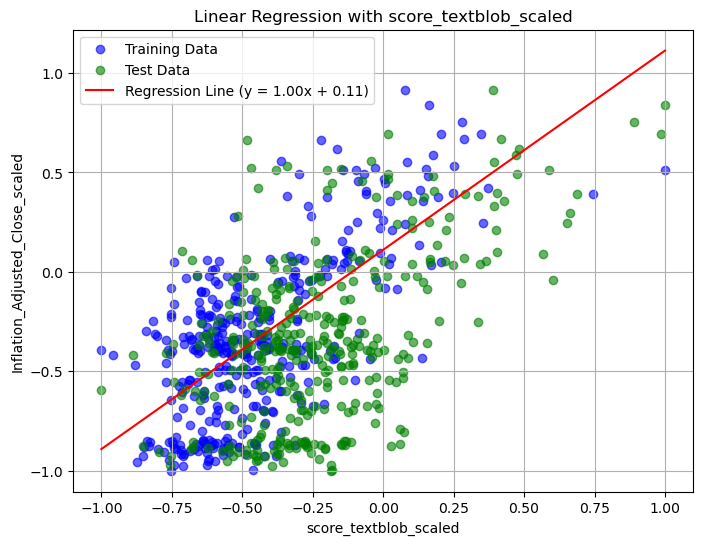

In [270]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_textblob, y_train_reg, alpha=0.6, label='Training Data', color='blue')
plt.scatter(X_test_textblob, y_test_reg, alpha=0.6, label='Test Data', color='green')

x_values = np.linspace(X_train_textblob.min(), X_train_textblob.max(), 100).reshape(-1, 1)
y_values = lin_reg.predict(x_values)
plt.plot(x_values, y_values, color='red', label=f'Regression Line (y = {lin_reg.coef_[0]:.2f}x + {lin_reg.intercept_:.2f})')

plt.xlabel('score_textblob_scaled')
plt.ylabel('Inflation_Adjusted_Close_scaled')
plt.title('Linear Regression with score_textblob_scaled')
plt.legend()
plt.grid()
plt.show()


#### **Predict using VADER Sentiment Scores**

In [271]:
X_train_vader, y_train_reg = monthly_train[['sentiment_score_VADER_scaled']], monthly_train['Inflation_Adjusted_Close_scaled']
X_test_vader, y_test_reg = monthly_test[['sentiment_score_VADER_scaled']], monthly_test['Inflation_Adjusted_Close_scaled']

In [272]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_vader, y_train_reg)
y_train_pred = lin_reg.predict(X_train_vader)
y_test_pred = lin_reg.predict(X_test_vader)

In [273]:
mse_train = mean_squared_error(y_train_reg, y_train_pred)
r2_train = r2_score(y_train_reg, y_train_pred)

mse_test = mean_squared_error(y_test_reg, y_test_pred)
r2_test = r2_score(y_test_reg, y_test_pred)

print(f"Training MSE: {mse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")

Training MSE: 0.1574, R2: 0.0890
Test MSE: 0.1586, R2: 0.0821


/Users/jamesstrong/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


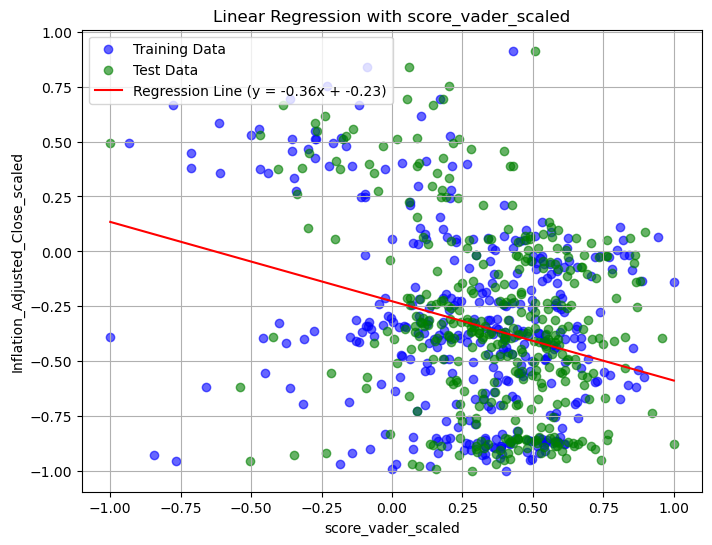

In [274]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_vader, y_train_reg, alpha=0.6, label='Training Data', color='blue')
plt.scatter(X_test_vader, y_test_reg, alpha=0.6, label='Test Data', color='green')

x_values = np.linspace(X_train_vader.min(), X_train_vader.max(), 100).reshape(-1, 1)
y_values = lin_reg.predict(x_values)
plt.plot(x_values, y_values, color='red', label=f'Regression Line (y = {lin_reg.coef_[0]:.2f}x + {lin_reg.intercept_:.2f})')

plt.xlabel('score_vader_scaled')
plt.ylabel('Inflation_Adjusted_Close_scaled')
plt.title('Linear Regression with score_vader_scaled')
plt.legend()
plt.grid()
plt.show()


# BETTER LIN REG??

In [304]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define X_train, y_train, X_test, y_test
X_train_textblob, y_train_reg = monthly_train[['score_textblob_scaled']], monthly_train['Inflation_Adjusted_Close_scaled']
X_test_textblob, y_test_reg = monthly_test[['score_textblob_scaled']], monthly_test['Inflation_Adjusted_Close_scaled']

# Create a pipeline to combine polynomial features with Ridge/Lasso regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # For generating polynomial features
    ('regressor', Ridge())           # Default to Ridge, can switch to Lasso in grid search
])

# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2, 3, 4],                # Degrees of polynomial to try
    'regressor': [Ridge(), Lasso()],             # Try both Ridge and Lasso
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]  # Regularization strengths
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_textblob, y_train_reg)

# Best model from grid search
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predictions using the best model
y_train_pred = best_model.predict(X_train_textblob)
y_test_pred = best_model.predict(X_test_textblob)

# Evaluate performance
mse_train = mean_squared_error(y_train_reg, y_train_pred)
r2_train = r2_score(y_train_reg, y_train_pred)
mse_test = mean_squared_error(y_test_reg, y_test_pred)
r2_test = r2_score(y_test_reg, y_test_pred)

# Print results
print("Best Model Parameters:", best_params)
print(f"Training MSE: {mse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Model Parameters: {'poly__degree': 1, 'regressor': Ridge(), 'regressor__alpha': 0.1}
Training MSE: 0.0939, R2: 0.4569
Test MSE: 0.1788, R2: -0.0350


## **Classification: Logistic Regression**

In [275]:
monthly_test.columns

Index(['sentiment_score_VADER', 'score_textblob',
       'sentiment_score_VADER_nonzero', 'score_textblob_nonzero',
       'Inflation_Adjusted_Close', 'Pct_Change', 'Admin', 'Archives', 'Arts',
       'At Home', 'Automobiles', 'Blogs', 'Books', 'Booming', 'Briefing',
       'Burst', 'Business Day', 'Climate', 'College', 'Corrections',
       'Critic's Choice', 'Crosswords & Games', 'Editors Picks', 'Education',
       'Fashion & Style', 'Food', 'Giving', 'Global Home',
       'Great Homes & Destinations', 'Guides', 'Health', 'Home & Garden',
       'Homepage', 'International Home', 'Job Market', 'Lens', 'Magazine',
       'Movies', 'Multimedia/Photos', 'NYT Now', 'Neediest Cases', 'New York',
       'Obituaries', 'Open', 'Opinion', 'Parenting', 'Podcasts',
       'Public Editor', 'Reader Center', 'Real Estate', 'Science',
       'Smarter Living', 'Sports', 'Style', 'Sunday Review', 'T Brand',
       'T Magazine', 'Technology', 'The Learning Network', 'The Upshot',
       'The Weekly', 

In [276]:
predictors = ['sentiment_score_VADER', 'score_textblob',
       'sentiment_score_VADER_nonzero', 'score_textblob_nonzero', 'Admin', 'Archives', 'Arts',
       'At Home', 'Automobiles', 'Blogs', 'Books', 'Booming', 'Briefing',
       'Burst', 'Business Day', 'Climate', 'College', 'Corrections',
       'Crosswords & Games', 'Editors Picks', 'Education',
       'Fashion & Style', 'Food', 'Giving', 'Global Home',
       'Great Homes & Destinations', 'Guides', 'Health', 'Home & Garden',
       'Homepage', 'International Home', 'Job Market', 'Lens', 'Magazine',
       'Movies', 'Multimedia/Photos', 'NYT Now', 'Neediest Cases', 'New York',
       'Obituaries', 'Open', 'Opinion', 'Parenting', 'Podcasts',
       'Public Editor', 'Reader Center', 'Real Estate', 'Science',
       'Smarter Living', 'Sports', 'Style', 'Sunday Review', 'T Brand',
       'T Magazine', 'Technology', 'The Learning Network', 'The Upshot',
       'The Weekly', 'Theater', 'Times Insider', 'Times Topics',
       'Today’s Paper', 'Topics', 'Travel', 'U.S.', 'Universal', 'UrbanEye',
       'Video', 'Washington', 'Watching', 'Week in Review', 'Well', 'World',
       'Your Money', 'membercenter', 'nationchallenged', 'none',
       'nytfrontpage', 'readersopinions', 'timesselect',
       'sentiment_score_VADER_scaled', 'score_textblob_scaled',
       'sentiment_score_VADER_nonzero_scaled', 'score_textblob_nonzero_scaled', ]
X_train, X_test = monthly_train[predictors], monthly_test[predictors]

In [277]:
# Tune hyperparameters
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

log_reg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train_class)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [278]:
# Get the best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_logit_model = grid_search.best_estimator_

Best Parameters: {'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}


In [279]:
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

In [280]:
# Test the model
y_pred = best_logit_model.predict(X_test_aligned)
y_pred = best_logit_model.predict(X_test_aligned)
y_proba = best_logit_model.predict_proba(X_test_aligned)[:, 1]

In [281]:
# Metrics
print("Accuracy:", accuracy_score(y_test_class, y_pred))
mse_logit = mean_squared_error(y_train_class, y_proba)
print("Mean Squared Error for Logistic Regression:", mse_logit)

Accuracy: 0.6091644204851752
Mean Squared Error for Logistic Regression: 0.2479224581164856


In [282]:
coeffs_logit = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_logit_model.coef_[0]
})
display(coeffs_logit)

Feature  Coefficient
0                  sentiment_score_VADER          0.0
1                         score_textblob          0.0
2          sentiment_score_VADER_nonzero          0.0
3                 score_textblob_nonzero          0.0
4                                  Admin          0.0
..                                   ...          ...
79                           timesselect          0.0
80          sentiment_score_VADER_scaled          0.0
81                 score_textblob_scaled          0.0
82  sentiment_score_VADER_nonzero_scaled          0.0
83         score_textblob_nonzero_scaled          0.0

[84 rows x 2 columns]

In [283]:
top_10_coeffs = coeffs_logit.reindex(coeffs_logit['Coefficient'].abs().sort_values(ascending=False).index)
top_10_coeffs.head(10)

Feature  Coefficient
14           Business Day     0.000194
38               New York     0.000053
0   sentiment_score_VADER     0.000000
54             Technology     0.000000
61          Today’s Paper     0.000000
60           Times Topics     0.000000
59          Times Insider     0.000000
58                Theater     0.000000
57             The Weekly     0.000000
56             The Upshot     0.000000

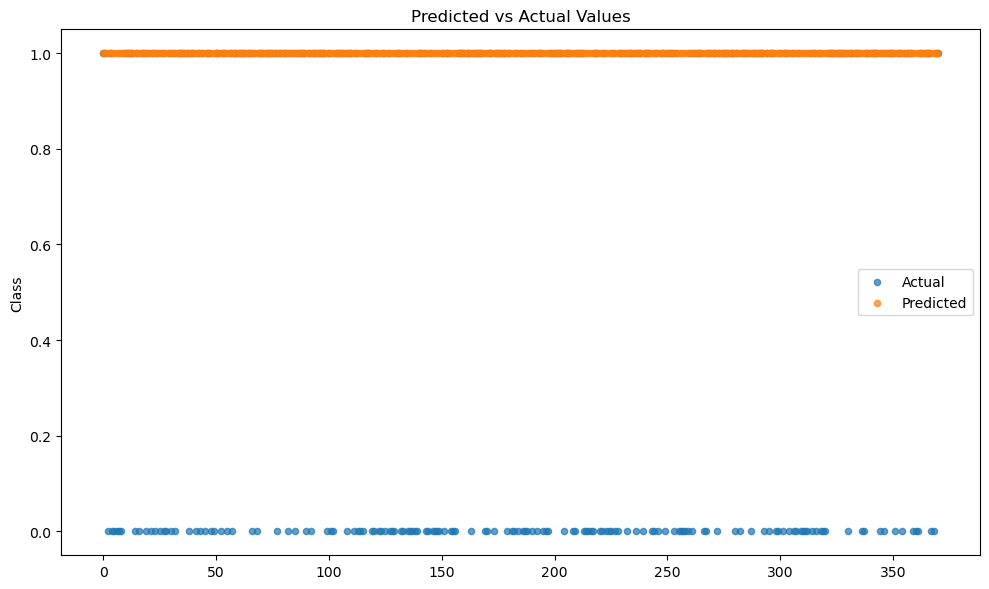

In [284]:
X_test, y_test_class

y_test_pred = best_logit_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_class)), y_test_class, label="Actual", alpha=0.7, s=20)
plt.scatter(range(len(y_test_class)), y_test_pred, label="Predicted", alpha=0.7, s=20)
plt.legend()
plt.title("Predicted vs Actual Values")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

In comparison to the baseline model for the classication problem, majority class predictor, our Logistic Regression model does no better. When tuning the hyperparameters for this model, the Grid Search picked the strongest regularization constant, which essentially pushed all coefficients to 0. This results in always predicting 1 (increased price next month), which is the same as the majority class predictor. 

## **Regression: kNN**

As stock prices are sequential and build upon each other (for example, prices rising on Monday might indicate rising confidence in the market, prompting more investors to buy, further increasing prices on Tuesday), we will fit a kNN model on the data to see if such a model can better model the relationship between NYT headlines and S&P data. For this section's model set up, we train the kNN model using the month time point.

In [285]:
predictors_scaled = [
    'score_textblob_nonzero_scaled',
    'score_textblob_scaled',
    # 'sentiment_score_VADER_nonzero_scaled',
    # 'sentiment_score_VADER_scaled',
]

In [286]:
from sklearn.neighbors import KNeighborsRegressor

X_train, y_train_reg = monthly_train[predictors_scaled], monthly_train['Inflation_Adjusted_Close']
X_test, y_test_reg = monthly_test[predictors_scaled], monthly_test['Inflation_Adjusted_Close']

In [287]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 7, 10, 15, 20, 50, 100], 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train_reg)
best_knn_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Best Cross-Validation Accuracy: -69207.80862002322


In [288]:
y_test_pred = best_knn_model.predict(X_test)

mse = mean_squared_error(y_test_reg, y_test_pred)
r2 = r2_score(y_test_reg, y_test_pred)

print("\nEvaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)


Evaluation Metrics:
Mean Squared Error (MSE): 53536.878585531485
R-squared (R²): 0.49152021963301484


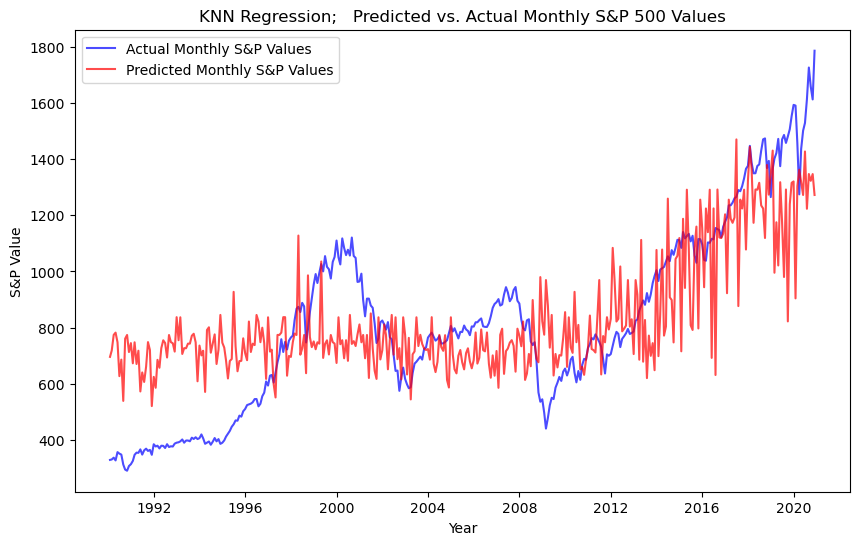

In [289]:
sorted_indices = np.argsort(X_test.index)
sorted_X_test = X_test.iloc[sorted_indices]
sorted_y_test_reg = y_test_reg.iloc[sorted_indices]
sorted_y_test_pred = y_test_pred[sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(sorted_X_test.index, sorted_y_test_reg, label="Actual Monthly S&P Values", color="blue", alpha=0.7)
plt.plot(sorted_X_test.index, sorted_y_test_pred, label="Predicted Monthly S&P Values", color="red", alpha=0.7)
plt.title("KNN Regression;   Predicted vs. Actual Monthly S&P 500 Values")
plt.xlabel("Year")
plt.ylabel("S&P Value")
plt.legend()
plt.show()


# SIMULATION???

In [290]:
y_test_pred = best_knn_model.predict(X_test)

simulation_df = pd.DataFrame({
    'Actual_Price': y_test_reg.values,
    'Predicted_Price': y_test_pred,
    'Next_Actual_Price': y_test_reg.shift(-1).values
}).dropna()

simulation_df['Action'] = np.where(simulation_df['Predicted_Price'] > simulation_df['Actual_Price'], 'Buy', 'Sell')
simulation_df['Profit/Loss'] = np.where(
    simulation_df['Action'] == 'Buy',
    simulation_df['Next_Actual_Price'] - simulation_df['Actual_Price'],
    0 
)

total_profit = simulation_df['Profit/Loss'].sum()
winning_trades = (simulation_df['Profit/Loss'] > 0).sum()
losing_trades = (simulation_df['Profit/Loss'] < 0).sum()

print("\nSimulation Results:")
print(f"Total Profit/Loss: ${total_profit:.2f}")
print(f"Number of Winning Trades: {winning_trades}")
print(f"Number of Losing Trades: {losing_trades}")
print(f"Accuracy of Winning Trades: {winning_trades / len(simulation_df) * 100:.2f}%")

print("\nSimulation Data (First 10 Rows):")
print(simulation_df.head(10))



Simulation Results:
Total Profit/Loss: $753.80
Number of Winning Trades: 115
Number of Losing Trades: 72
Accuracy of Winning Trades: 31.08%

Simulation Data (First 10 Rows):
   Actual_Price  Predicted_Price  Next_Actual_Price Action  Profit/Loss
0    329.079987       695.774944         330.593569    Buy     1.513583
1    330.593569       718.644982         337.032273    Buy     6.438704
2    337.032273       773.908371         327.207125    Buy    -9.825148
3    327.207125       782.090876         356.753109    Buy    29.545984
4    356.753109       747.598453         351.405301    Buy    -5.347808
5    351.405301       627.174680         347.962638    Buy    -3.442663
6    347.962638       685.995626         312.510636    Buy   -35.452002
7    312.510636       539.041998         294.500932    Buy   -18.009704
8    294.500932       760.653005         290.554723    Buy    -3.946209
9    290.554723       773.680787         307.277862    Buy    16.723139


## **Random Forest Model**

In [291]:
forest_predictors = [
    'score_textblob_nonzero_scaled',
    'score_textblob_scaled',
    'sentiment_score_VADER_nonzero_scaled',
    'sentiment_score_VADER_scaled',
]


In [292]:
display(monthly_train.columns)

X_train, y_train_reg = monthly_train[forest_predictors], monthly_train['Inflation_Adjusted_Close']
X_test, y_test_reg = monthly_test[forest_predictors], monthly_test['Inflation_Adjusted_Close']
y_train_class = monthly_train['Price_Change_Target']
y_test_class = monthly_test['Price_Change_Target']


Index(['sentiment_score_VADER', 'score_textblob',
       'sentiment_score_VADER_nonzero', 'score_textblob_nonzero',
       'Inflation_Adjusted_Close', 'Pct_Change', 'Admin', 'Archives', 'Arts',
       'At Home', 'Automobiles', 'Blogs', 'Books', 'Booming', 'Briefing',
       'Burst', 'Business Day', 'Climate', 'College', 'Corrections',
       'Critic's Choice', 'Crosswords & Games', 'Editors Picks', 'Education',
       'Fashion & Style', 'Feeds', 'Food', 'Giving', 'Global Home',
       'Great Homes & Destinations', 'Guides', 'Health', 'Home & Garden',
       'Homepage', 'International Home', 'Job Market', 'Lens', 'Magazine',
       'Movies', 'Multimedia/Photos', 'NYT Now', 'Neediest Cases', 'New York',
       'Obituaries', 'Open', 'Opinion', 'Parenting', 'Podcasts',
       'Public Editor', 'Reader Center', 'Real Estate', 'Science',
       'Slideshows', 'Smarter Living', 'Sports', 'Style', 'Sunday Review',
       'T Brand', 'T Magazine', 'Technology', 'The Learning Network',
       'The 

In [293]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10, 15, 20],    
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],   
    'max_features': [None, 'sqrt', 'log2'],     
    'ccp_alpha': [0.0, 0.001, 0.01],      
}

dt_classifier = DecisionTreeClassifier(random_state=42)

k = 5
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=k, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train_class)

best_dt_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Accuracy: 0.5850810810810811


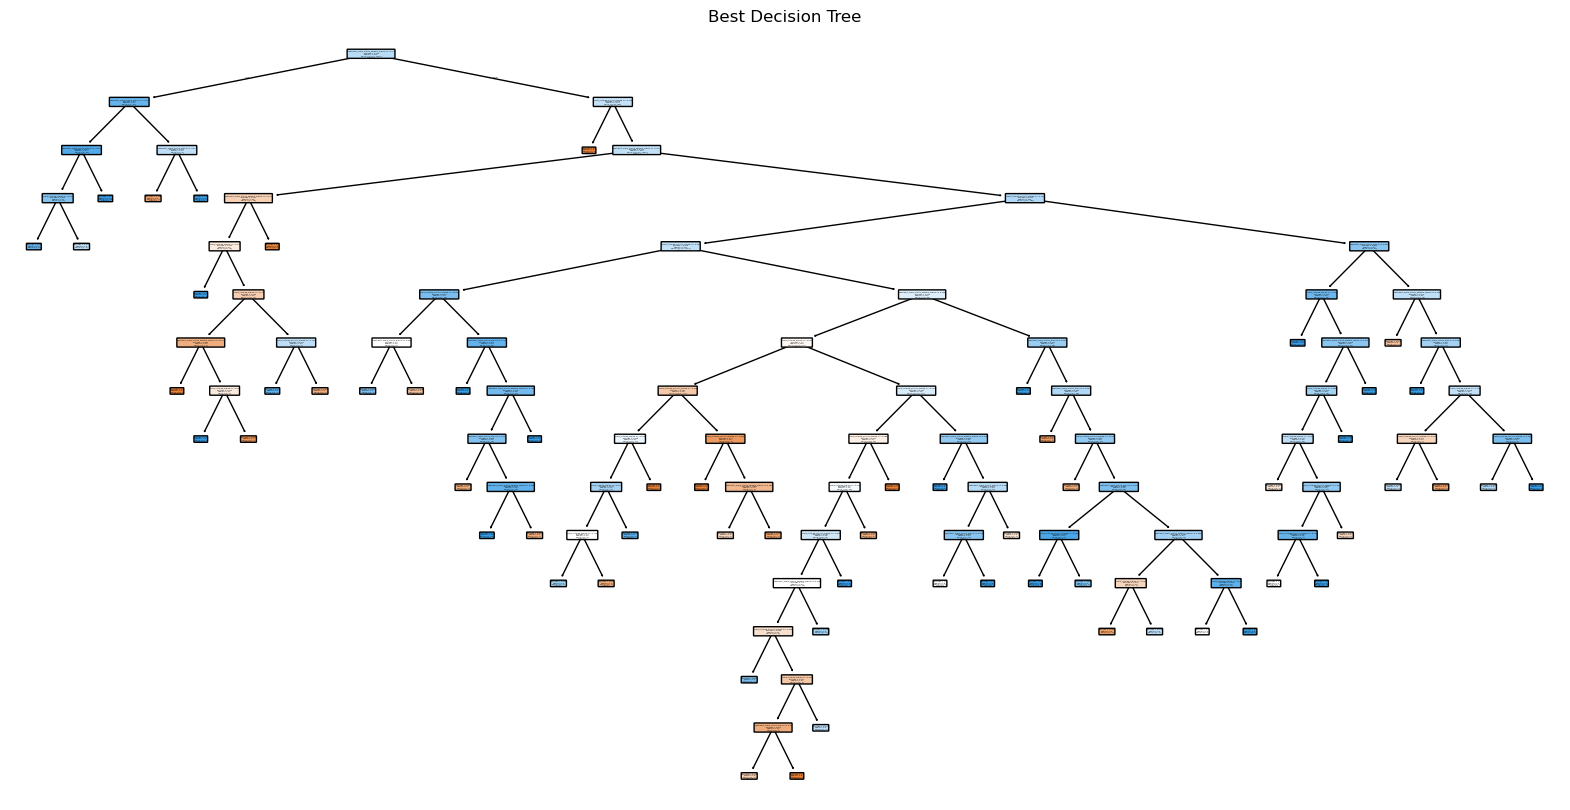

In [294]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model, 
    feature_names=X_train.columns if hasattr(X_train, 'columns') else None, 
    class_names=best_dt_model.classes_.astype(str),
    filled=True,
    rounded=True
)
plt.title("Best Decision Tree")
plt.show()

In [295]:
feature_importances = best_dt_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
sorted_features = X_train.columns[indices]
sorted_importances = feature_importances[indices]

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print("Feature Importance Table:")
print(feature_importance_df)

Feature Importance Table:
                                Feature  Importance
0         score_textblob_nonzero_scaled    0.269179
2  sentiment_score_VADER_nonzero_scaled    0.252834
1                 score_textblob_scaled    0.242292
3          sentiment_score_VADER_scaled    0.235695


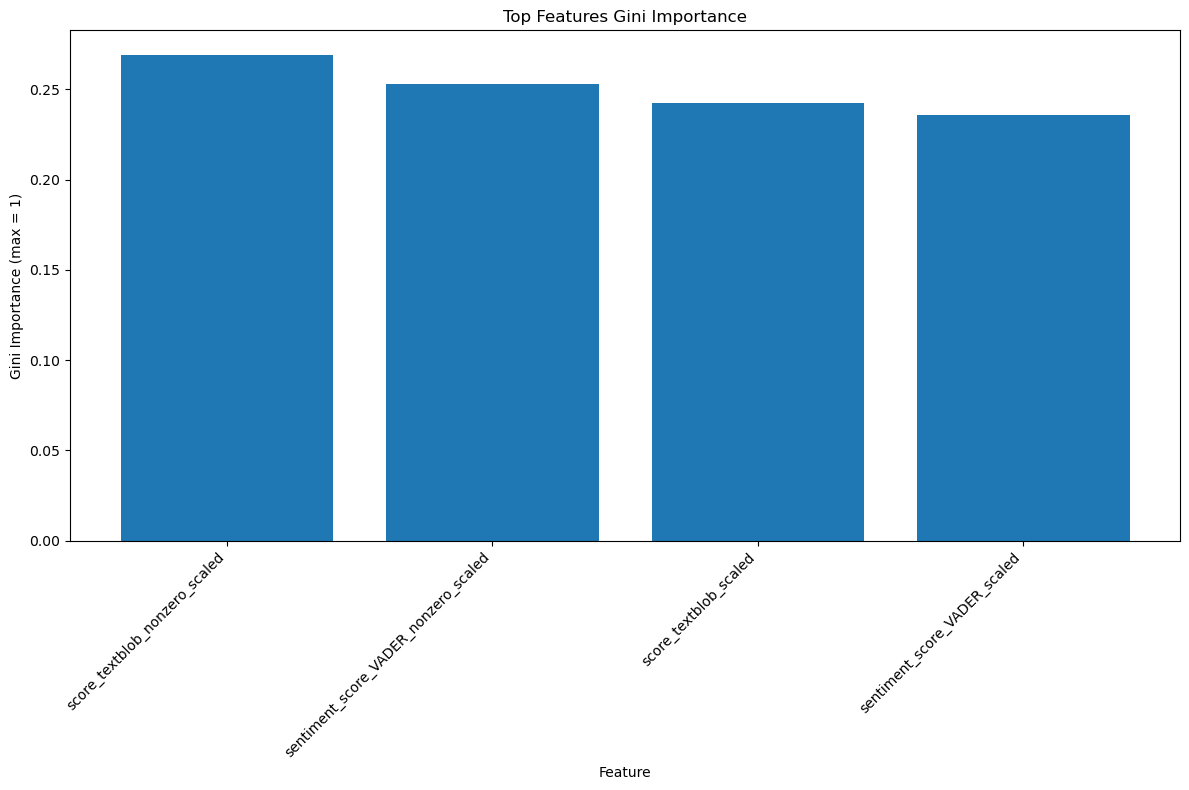

In [296]:
plt.figure(figsize=(12, 8))
plt.bar(sorted_features, sorted_importances)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top Features Gini Importance")
plt.ylabel("Gini Importance (max = 1)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

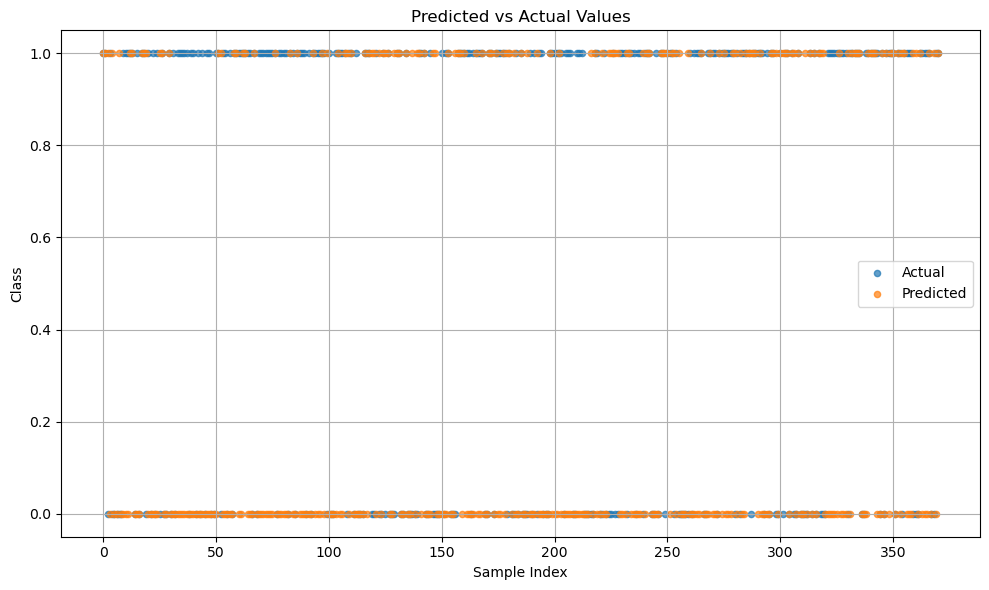

In [297]:
y_test_pred = best_dt_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_class)), y_test_class, label="Actual", alpha=0.7, s=20)
plt.scatter(range(len(y_test_class)), y_test_pred, label="Predicted", alpha=0.7, s=20)
plt.legend()
plt.title("Predicted vs Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.grid()
plt.tight_layout()
plt.show()

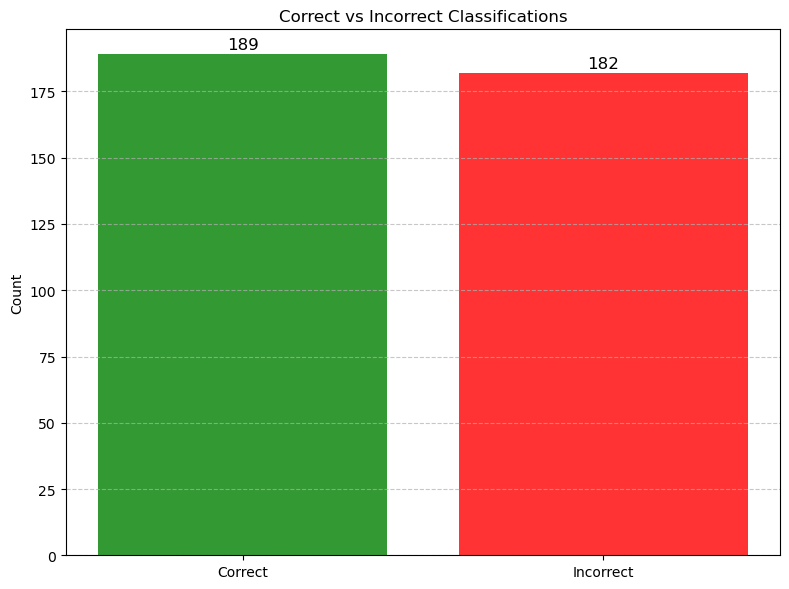

In [302]:

y_test_pred = best_dt_model.predict(X_test)

# Determine correctness of predictions
correctness = (y_test_pred == y_test_class).astype(int)  # 1 for correct, 0 for incorrect

# Count correct and incorrect classifications
correct_count = correctness.sum()
incorrect_count = len(correctness) - correct_count

# Data for the bar graph
categories = ['Correct', 'Incorrect']
counts = [correct_count, incorrect_count]

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['green', 'red'], alpha=0.8)
plt.title("Correct vs Incorrect Classifications")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add labels above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', fontsize=12)

plt.show()


In [298]:
print(classification_report(y_test_class, y_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.42      0.67      0.52       145
           1       0.66      0.41      0.50       226

    accuracy                           0.51       371
   macro avg       0.54      0.54      0.51       371
weighted avg       0.56      0.51      0.51       371



# SIMULATION???


Simulation Results with Decision Tree Classifier:
Total Profit/Loss: $1227.36
Number of Winning Trades: 91
Number of Losing Trades: 48
Accuracy of Winning Trades: 24.59%

Simulation Data (First 10 Rows):
   Actual_Price  Prediction  Next_Actual_Price Action  Profit/Loss
0    329.079987           1         330.593569    Buy     1.513583
1    330.593569           1         337.032273    Buy     6.438704
2    337.032273           1         327.207125    Buy    -9.825148
3    327.207125           0         356.753109   Sell     0.000000
4    356.753109           1         351.405301    Buy    -5.347808
5    351.405301           0         347.962638   Sell     0.000000
6    347.962638           0         312.510636   Sell     0.000000
7    312.510636           1         294.500932    Buy   -18.009704
8    294.500932           0         290.554723   Sell     0.000000
9    290.554723           0         307.277862   Sell     0.000000


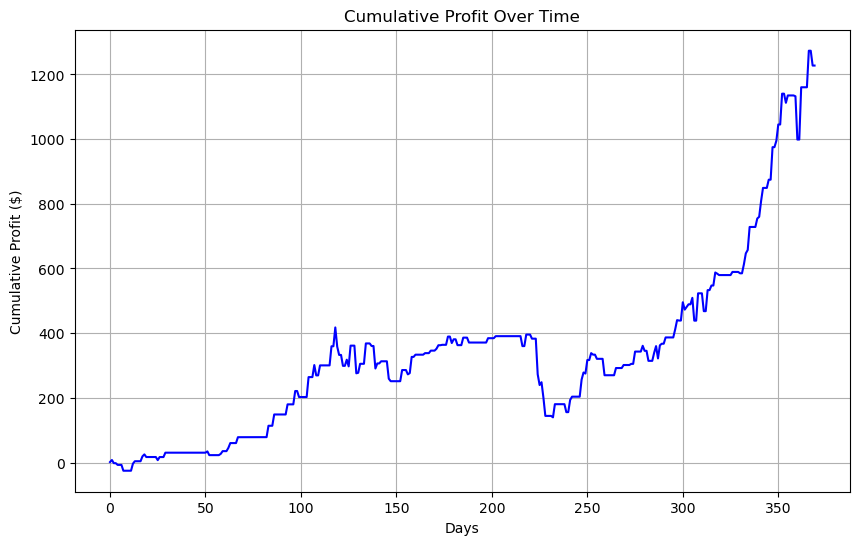

In [303]:
y_test_pred_class = best_dt_model.predict(X_test)

# Create a simulation DataFrame
simulation_df = pd.DataFrame({
    'Actual_Price': y_test_reg.values,
    'Prediction': y_test_pred_class,  # Model predictions (1 = Buy, 0 = Sell)
    'Next_Actual_Price': y_test_reg.shift(-1).values  # Shift actual prices to simulate the next day
}).dropna()  # Remove the last row since there's no next price for the last day

# Simulate actions and profit/loss
simulation_df['Action'] = np.where(simulation_df['Prediction'] == 1, 'Buy', 'Sell')
simulation_df['Profit/Loss'] = np.where(
    simulation_df['Action'] == 'Buy',
    simulation_df['Next_Actual_Price'] - simulation_df['Actual_Price'],  # Profit for "Buy"
    0  # Assume no profit/loss for "Sell"
)

# Summarize results
total_profit = simulation_df['Profit/Loss'].sum()
winning_trades = (simulation_df['Profit/Loss'] > 0).sum()
losing_trades = (simulation_df['Profit/Loss'] < 0).sum()

# Print Results
print("\nSimulation Results with Decision Tree Classifier:")
print(f"Total Profit/Loss: ${total_profit:.2f}")
print(f"Number of Winning Trades: {winning_trades}")
print(f"Number of Losing Trades: {losing_trades}")
print(f"Accuracy of Winning Trades: {winning_trades / len(simulation_df) * 100:.2f}%")

print("\nSimulation Data (First 10 Rows):")
print(simulation_df.head(10))

simulation_df['Cumulative_Profit'] = simulation_df['Profit/Loss'].cumsum()
simulation_df['Cumulative_Profit'].plot(figsize=(10, 6), title="Cumulative Profit Over Time", color='blue')
plt.xlabel("Days")
plt.ylabel("Cumulative Profit ($)")
plt.grid()
plt.show()


<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Interpreting Models and Results**

### **Interpretation of Baseline Models**

The majority class model was relatively simple. We created a new column, Price_Change_Target, that captures whether the closing S&P price would increase (1) or decrease (0) that month. Since the closing price increased approximately 61% of the time over the years, our model was able to predict with 61% accuracy on the test data.

For this linear regression model, we looked at both Textblob scaled and VADER scaled separately as predictors, resulting in a test MSE of 0.1793 and R2 of -0.0378 for textblob and an MSE of 0.1586 and R2 of 0.0821 for VADER. This implies that the Vader sentiment scores are a better predictor of scaled inflation adjusted s&p price, but visually looking at the graph, they seem to have fairly similar levels of how closely the regression line, with the textblob plot being better if anything. We know from examples like Anscombe’s quartet that R2 isn’t always the most accurate measure of predictiveness, so we don’t feel we have reason to discount textblob from this alone. 

### **Interpretation of the Logistic Regression Model**

Our Logistic Regression model had an accuracy of 0.609. The model was able to correctly predict the outcome for about 60.9% of the data points, which initially seemed quite a good result. However, in comparison to our majority class baseline model, our Logistic Regression performs exactly the same. This is due to the fine tuned hyperparameters, which uses LASSO penalization to shrink all of the coefficients to 0.



### **Interpretation of the Decision Tree Model**

Looking at the results for our Decision tree model, we got a precision of 0.42, implying that out of all predicted instances of class 0, only 42% are actually correct. This suggests many false positives for class 0. On the other hand, for class 1, 66% are correct, so this model likely has better precision for class 1 compared to class 0. 

In terms of recall, the model correctly identifies 67% of the actual class 0 instances. However, it misses the other 33% (false negatives). For class 1, the model identifies only 41% of the actual class 1 instances, which is quite low, meaning it has many false negatives.

For the f1-score, we got 0.52 for class 0, which means the model leans slightly toward better recall, whereas the f1-score of 0.5 for class 1 likely means the balance of precision and recall is poor for this class.

Accuracy-wise, the model correctly classifies 51% of all samples. This is not great, since it’s only slightly better than random guessing.
Our macro average of 0.54 indicates that the model is moderately balanced between classes, but still performs poorly overall, and our weighted average of 0.56 suggests a slight bias toward class 1.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Final Model Pipeline**

To assess the changes in S&P 500 closing price for a month, we will first take the headline for each month and perform sentiment analysis both using VADER and textBlob, and normalize these scores between -1 and 1. We will then also calculate the VADER and TextBlob scores excluding all the zero scores. For each month, we will take the average of these sentiment values and for that month and pass those values into our fitted random forest. This gives us a slighlty better accuracy than majority class prediction (the S&P will always increase).

This will provide us with a class indicator if the S&P500 will increase or decrease in value. The linear regression modle and KNN some some possible signal, but as discussed earlier there is a lot of noise in this data. For example, it is important to note that the S&P 500 is affected by many economic factors that are not accounted for here aside from just adjusting for inflation. Before the final milestone, we will continue working with both class predictor models and price predicting models to see if we can extract noise using any other metrics. As seen in our EDA, there appears to be less noise in the yearly data as well, however this longer time frame is less realistic in an investment context.